# 1. Importing Libraries

In [13]:
import os, sys, re, csv, time
from pathlib import Path
from itertools import product

import numpy as np
import pandas as pd
import cv2
import pydicom
from pydicom.dataset import Dataset

from scipy.ndimage import gaussian_filter, distance_transform_edt
from scipy import ndimage as ndi
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.optimize import least_squares
from numpy.fft import rfft, rfftfreq

from skimage import exposure, morphology, measure, util
from skimage.filters import sato, apply_hysteresis_threshold, meijering, threshold_otsu
from skimage.morphology import (
    binary_dilation, binary_closing, binary_opening,
    remove_small_holes, remove_small_objects,
    reconstruction, disk, skeletonize
)
from skimage.segmentation import clear_border
from skimage.graph import route_through_array

import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image, ImageOps, ImageChops
import torch
from dataclasses import dataclass
from typing import Tuple, List, Optional, Dict, Any
import torchvision.transforms as T
from DeepSA.models import UNet
from DeepSA.datasets import tophat
from DeepSA.utils import fusion_predict, make_mask, clear_mask


# 2. 3D Reconstruction from 2D Plots

## 2.1 Point Coordinates Extraction from PNG Plot

In [ ]:
def _kill_border(u8, px=6):
    """把靠边 px 像素都置 0，杀掉内框/坐标轴"""
    m = u8.copy()
    if m.ndim == 3:  # 保护一下三通道
        m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    H, W = m.shape
    if px > 0:
        m[:px, :] = 0; m[-px:, :] = 0; m[:, :px] = 0; m[:, -px:] = 0
    return m

def _component_touches_border(comp255, px=4, frac=0.25):
    M = comp255 > 0
    H, W = M.shape
    border = np.zeros_like(M, bool)
    border[:px,:] = True; border[-px:,:] = True; border[:,:px] = True; border[:,-px:] = True
    touch = (M & border).sum()
    area  = M.sum()
    return area > 0 and (touch / max(area,1)) > frac

def _border_penalty(shape, px=6):
    H, W = shape
    yy = np.minimum(np.arange(H), np.arange(H)[::-1])[:,None]
    xx = np.minimum(np.arange(W), np.arange(W)[::-1])[None,:]
    d = np.minimum(yy, xx).astype(np.float32)
    return (px - np.clip(d, 0, px)) / max(px,1)  # 边缘=1, 内部=0

# ---- 新增：骨架剪枝（去掉短枝）----
def _prune_skeleton(skel255, min_len=20):
    sk = (skel255>0).astype(np.uint8)
    H,W = sk.shape
    changed = True
    while changed:
        changed = False
        ys, xs = np.where(sk>0)
        for y,x in zip(ys, xs):
            # 统计8邻域
            cnt = 0
            nbr = []
            for dy in (-1,0,1):
                for dx in (-1,0,1):
                    if dx==0 and dy==0: continue
                    yy,xx = y+dy, x+dx
                    if 0<=yy<H and 0<=xx<W and sk[yy,xx]>0:
                        cnt += 1; nbr.append((yy,xx))
            if cnt==1:
                # 从这个端点往前走，若很短就剪掉
                path = [(y,x)]
                py, px = y, x
                for _ in range(min_len):
                    # 找唯一的下一点
                    nxt = []
                    for dy in (-1,0,1):
                        for dx in (-1,0,1):
                            if dx==0 and dy==0: continue
                            yy,xx = py+dy, px+dx
                            if 0<=yy<H and 0<=xx<W and sk[yy,xx]>0 and (yy,xx) not in path:
                                nxt.append((yy,xx))
                    if len(nxt)!=1: break
                    py,px = nxt[0]
                    path.append((py,px))
                if len(path) < min_len:
                    for yy,xx in path: sk[yy,xx]=0
                    changed = True
    return sk*255



# 2) 新增：计算“贴边比例”（用于评分惩罚）
def _border_touch_ratio(path_rc, H, W, thr=3):
    xs, ys = path_rc[:,1], path_rc[:,0]   # path_rc 是 (y,x)
    hit = ((xs < thr) | (xs > W - 1 - thr) | (ys < thr) | (ys > H - 1 - thr)).sum()
    return hit / max(1, len(path_rc))



def _norm01(a):
    a = a.astype(np.float32)
    mn, mx = a.min(), a.max()
    return (a - mn) / (mx - mn + 1e-8)

def _build_cost_image(crop_bgr, hue_center=None):
    # 1) 线结构增强（对细长亮线特别友好）
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)
    vessel = sato(_norm01(gray), sigmas=tuple(range(1, 5)))   # 细到粗的多尺度
    vessel_n = _norm01(vessel)

    # 2) 可选颜色相似度（自动抓主色相，不强制指定）
    cost = 1.0 - vessel_n   # vessel 强 => cost 低
    if hue_center is not None:
        hsv = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(hsv)
        # 色相圆距离（0~1），饱和度越高越可信
        d = np.minimum(np.abs(H - hue_center), 180 - np.abs(H - hue_center)) / 90.0
        color_penalty = _norm01(d) * (1.0 - _norm01(S)) * 0.5
        cost = _norm01(cost + color_penalty)

    # 3) 加一点常数避免 0 权重
    return _norm01(cost) + 1e-3

def _pick_hue_center(crop_bgr):
    hsv = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    mask = (S >= 60) & (V >= 50)
    if np.count_nonzero(mask) < 200:
        return None
    hist, _ = np.histogram(H[mask], bins=181, range=(0,181))
    h = int(hist.argmax())
    return h


def find_plot_roi(img, fallback_margin=0.05):
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ed = cv2.Canny(gray, 60, 160)
    ed = cv2.dilate(ed, np.ones((3,3),np.uint8), 1)
    cnts, _ = cv2.findContours(ed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best, best_area = None, 0
    for c in cnts:
        x,y,wc,hc = cv2.boundingRect(c)
        area = wc*hc
        if 0.25*h*w < area < 0.98*h*w and area > best_area:
            best_area, best = area, (x,y,x+wc,y+hc)
    if best is None:
        m = int(fallback_margin*min(h,w))
        return (m,m,w-m,h-m)
    return best

def _farthest_pair_on_mask(mask255):
    # 取骨架后“直径”两端作为端点
    from collections import deque
    sk = (mask255 > 0).astype(np.uint8)
    ys, xs = np.where(sk)
    if len(xs) == 0: return None, None
    pts = list(zip(xs, ys))
    idx = {p:i for i,p in enumerate(pts)}
    nbrs = [[] for _ in pts]
    for k,(x,y) in enumerate(pts):
        for dx in (-1,0,1):
            for dy in (-1,0,1):
                if dx==0 and dy==0: continue
                q=(x+dx,y+dy); j=idx.get(q)
                if j is not None: nbrs[k].append(j)
    def bfs(start):
        q = deque([start]); dist={start:0}; parent={start:-1}; last=start
        while q:
            u=q.popleft(); last=u
            for v in nbrs[u]:
                if v in dist: continue
                dist[v]=dist[u]+1; parent[v]=u; q.append(v)
        return last, dist, parent
    a = 0
    b,_,_  = bfs(a)
    c,_,p2 = bfs(b)
    # 回溯 b->c
    path=[]; u=c
    while u!=-1:
        path.append(pts[u]); u=p2.get(u,-1)
    return path[0], path[-1]   # 两端点 (x,y)

def extract_curve_points_full(img_bgr, roi, max_gap_pct=0.06, debug=False):
    """
    颜色无先验：多候选 + 去网格 + 骨架 + 测地最短路，拿到整段曲线
    返回：按路径排序的像素坐标 (N,2)，全局坐标
    """
    x0,y0,x1,y1 = roi
    crop = img_bgr[y0:y1, x0:x1]

    # ——(A) 先做一个“粗分割”得到若干候选——
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    # 去掉网格与坐标轴
    hor = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(31,1)))
    ver = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(1,31)))
    base = cv2.subtract(gray, cv2.max(hor, ver))
    base = cv2.GaussianBlur(base, (3,3), 0)

    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    L,A,B = cv2.split(cv2.cvtColor(crop, cv2.COLOR_BGR2LAB))
    chroma = np.sqrt((A-128.0)**2 + (B-128.0)**2)

    # 色度+亮度
    c_thr = np.percentile(chroma, 99)*0.30
    v_thr = np.percentile(hsv[:,:,2], 75)*0.65
    m_ch  = ((chroma>c_thr) & (hsv[:,:,2]>v_thr)).astype(np.uint8)*255
    m_ch  = cv2.morphologyEx(m_ch, cv2.MORPH_OPEN,  np.ones((3,3),np.uint8), 1)
    m_ch  = cv2.morphologyEx(m_ch, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), 1)

    # 色相峰（自动挑主色）
    h0 = _pick_hue_center(crop)
    if h0 is not None:
        def _mask_h(hc):
            band=14
            if hc < band:
                m1 = cv2.inRange(hsv,(0,60,50),(hc+band,255,255))
                m2 = cv2.inRange(hsv,(180-(band-hc),60,50),(180,255,255))
                return cv2.bitwise_or(m1,m2)
            if hc+band>180:
                m1 = cv2.inRange(hsv,(0,60,50),((hc+band)-180,255,255))
                m2 = cv2.inRange(hsv,(hc-band,60,50),(180,255,255))
                return cv2.bitwise_or(m1,m2)
            return cv2.inRange(hsv,(hc-band,60,50),(hc+band,255,255))
        m_h  = _mask_h(h0)
    else:
        m_h  = np.zeros_like(m_ch)

    # Canny 作兜底
    edges = cv2.Canny(base, 40, 100)

    # 综合候选
    mask0 = cv2.bitwise_or(m_ch, m_h)
    mask0 = cv2.bitwise_or(mask0, edges)
    mask0 = (mask0>0).astype(np.uint8)*255

    # 👉(1) 杀边 & 贴边连通域过滤
    mask0 = _kill_border(mask0, px=6)
    num, lab, stats, _ = cv2.connectedComponentsWithStats(mask0, connectivity=8)
    keep = np.zeros_like(mask0, np.uint8)
    for i in range(1, num):
        if stats[i, cv2.CC_STAT_AREA] < 150:  # 小噪点
            continue
        comp = (lab==i).astype(np.uint8)*255
        if _component_touches_border(comp, px=4, frac=0.25):
            continue
        keep = cv2.bitwise_or(keep, comp)
    mask = keep if keep.any() else mask0
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8), 1)

    # 👉(2) 骨架 + 剪枝（避免短枝当端点）
    try:
        import cv2.ximgproc as xi
        skel = xi.thinning(mask)
    except Exception:
        from skimage.morphology import skeletonize
        skel = (skeletonize((mask>0).astype(bool)).astype(np.uint8)*255)
    skel = _prune_skeleton(skel, min_len=max(18, int(0.02*min(mask.shape))))
    
    pA, pB = _farthest_pair_on_mask(skel)   # 你的函数不变
    if pA is None or pB is None:
        return np.empty((0,2), dtype=int)

    # 👉(3) “走廊约束”的代价图：走出走廊代价极高
    corridor = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                    (max(7, int(0.015*(x1-x0))), max(7, int(0.015*(y1-y0))))))
    corridor = (corridor>0).astype(np.uint8)
    cost = _build_cost_image(crop, hue_center=h0).astype(np.float32)  # 你原来的
    cost += 5.0 * _border_penalty(cost.shape, px=6)                   # 靠边惩罚
    cost[ corridor==0 ] += 1e3                                         # 走廊外禁止

    from skimage.graph import route_through_array
    start = (pA[1], pA[0]); end = (pB[1], pB[0])
    path_rc, _ = route_through_array(cost, start, end, geometric=True, fully_connected=True)
    path_rc = np.array(path_rc, dtype=int)

    # 回填全局坐标 + 轻微重采样（同你原来）
    pts = np.column_stack([path_rc[:,1] + x0, path_rc[:,0] + y0])
    d = np.sqrt(np.sum(np.diff(pts, axis=0)**2, axis=1)); s = np.insert(np.cumsum(d), 0, 0.0)
    if s[-1] > 0:
        N = min(600, max(200, pts.shape[0]))
        si = np.linspace(0, s[-1], N)
        xi = np.interp(si, s, pts[:,0]); yi = np.interp(si, s, pts[:,1])
        pts = np.column_stack([xi, yi]).astype(np.float32)
    if debug:
        dbg = crop.copy()
        for (x,y) in (pts - [x0,y0]).astype(int):
            cv2.circle(dbg, (int(x),int(y)), 1, (0,255,0), -1)
        cv2.imwrite("debug_curve_path.png", dbg)
    return pts

# ---------------------------
# 1) 提取像素坐标
# ---------------------------

def cv2_imread_any(path):
    path = str(path)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        data = np.fromfile(path, dtype=np.uint8)            # Unicode-safe
        img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return img

'''
def extract_curve_pixels(img_path):
    from pathlib import Path
    p = Path(img_path)
    assert p.exists(), f"文件不存在: {p.resolve()}"
    img = cv2_imread_any(p)
    assert img is not None, f"OpenCV 读图失败: {p.resolve()}"
    roi = find_plot_roi(img)
    pts_px = extract_curve_points_full(img, roi)
    if pts_px is None or len(pts_px) == 0:
        raise RuntimeError("未提取到曲线像素点")
    return img, roi, np.asarray(pts_px, dtype=np.float64)
'''

def extract_curve_pixels(img_path):
    img = cv2_imread_any(img_path)
    assert img is not None, f"读图失败: {img_path}"
    roi = find_plot_roi(img)
    pts_px = extract_curve_points_full(img, roi, debug=True)  # 你的“整段曲线”函数
    if pts_px is None or len(pts_px) == 0:
        raise RuntimeError("未提取到曲线像素点")
    # 统一成 float64，形如 [[px,py], ...]，是**全局像素坐标**
    pts_px = np.asarray(pts_px, dtype=np.float64)
    return img, roi, pts_px


# ---------------------------
# 2A) 用已知范围做线性映射（最省心）
# plane='xoz' 或 'yoz'；范围传 (min, max)
# ---------------------------
def map_pixels_by_ranges(pts_px, roi, plane='xoz',
                         x_range=None, y_range=None, z_range=None):
    x0,y0,x1,y1 = roi
    W = (x1 - x0); H = (y1 - y0)
    assert W > 0 and H > 0

    px = pts_px[:,0]; py = pts_px[:,1]

    # z 垂直：注意图像坐标向下增，物理 z 向上增
    assert z_range is not None, "必须提供 z_range=(z_min,z_max)"
    z_min, z_max = z_range
    z = z_min + ( (y1 - py) / H ) * (z_max - z_min)

    if plane.lower() == 'xoz':
        assert x_range is not None, "xoz 平面需要 x_range=(x_min,x_max)"
        x_min, x_max = x_range
        x = x_min + ( (px - x0) / W ) * (x_max - x_min)
        df = pd.DataFrame({"z": z, "x": x})
    else:  # 'yoz'
        assert y_range is not None, "yoz 平面需要 y_range=(y_min,y_max)"
        y_min, y_max = y_range
        y = y_min + ( (px - x0) / W ) * (y_max - y_min)
        df = pd.DataFrame({"z": z, "y": y})

    # 按 z 排序并去 z 重复
    order = np.argsort(df["z"].values)
    df = df.iloc[order]
    df = df.drop_duplicates(subset=["z"], keep="first").reset_index(drop=True)
    return df
'''
def map_pixels_by_ranges(pts_px, roi, plane='xoz',
                         x_range=None, y_range=None, z_range=None,
                         dedupe_by_z=False, sort_by_z=True):
    x0,y0,x1,y1 = roi
    W = (x1 - x0); H = (y1 - y0)
    assert W > 0 and H > 0

    px = pts_px[:,0]; py = pts_px[:,1]

    # 竖直像素 -> 物理 z（图像向下为正，因此用 y1 - py）
    assert z_range is not None
    z_min, z_max = z_range
    z = z_min + ((y1 - py) / H) * (z_max - z_min)

    if plane.lower() == 'xoz':
        assert x_range is not None
        x_min, x_max = x_range
        x = x_min + ((px - x0) / W) * (x_max - x_min)
        df = pd.DataFrame({"z": z, "x": x})
    else:
        assert y_range is not None
        y_min, y_max = y_range
        y = y_min + ((px - x0) / W) * (y_max - y_min)
        df = pd.DataFrame({"z": z, "y": y})

    if sort_by_z:
        df = df.sort_values("z", kind="mergesort").reset_index(drop=True)

    if dedupe_by_z:
        df = df.drop_duplicates(subset=["z"], keep="first").reset_index(drop=True)

    return df
'''
# ---------------------------
# 3) 保存像素坐标（便于后处理/复核）
# ---------------------------
def save_pixels_csv(path, pts_px):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df = pd.DataFrame({"px": pts_px[:,0], "py": pts_px[:,1]})
    df.to_csv(path, index=False)

In [29]:
XOZ_PATH = Path("Data/初赛数据-血管造影图像/自建-二维投影曲线图像/1/xoz平面投影.png")
YOZ_PATH = Path("Data/初赛数据-血管造影图像/自建-二维投影曲线图像/1/yoz平面投影.png")
OUT_DIR  = Path("./out_chart3d")
OUT_DIR.mkdir(parents=True, exist_ok=True)  


_, roi_xoz, pts_xoz = extract_curve_pixels(XOZ_PATH)
df_xoz = map_pixels_by_ranges(pts_xoz, roi_xoz, plane="xoz",
                              x_range=(-0.55, 3.0), z_range=(-0.9, 2.34))
df_xoz.to_csv(f"{OUT_DIR}/1_xoz_zx.csv", index=False)



_, roi_yoz, pts_yoz = extract_curve_pixels(YOZ_PATH)
df_yoz = map_pixels_by_ranges(pts_yoz, roi_yoz, plane="yoz",
                              y_range=(-1.1, -0.3), z_range=(-0.9, 2.34))
df_yoz.to_csv(f"{OUT_DIR}/1_yoz_zy.csv", index=False)


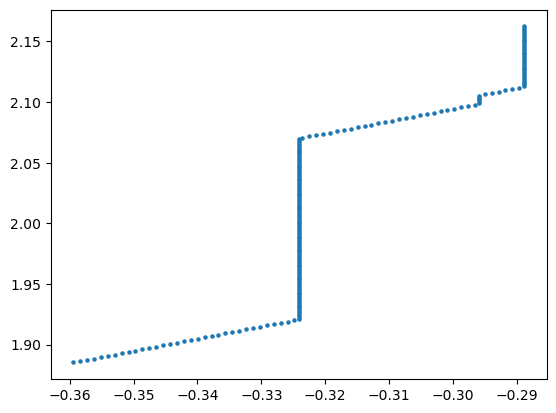

In [30]:
zx = pd.read_csv('out_chart3d/1_xoz_zx.csv')
x = zx['x']
z = zx['z']
plt.scatter(x, z, s=5)


In [88]:
XOZ_PATH = Path("Data/初赛数据-血管造影图像/自建-二维投影曲线图像/2/xoz平面投影.png")
YOZ_PATH = Path("Data/初赛数据-血管造影图像/自建-二维投影曲线图像/2/yoz平面投影.png")
OUT_DIR  = Path("./out_chart3d")
OUT_DIR.mkdir(parents=True, exist_ok=True)  



_, roi_xoz, pts_xoz = extract_curve_pixels(XOZ_PATH)
df_xoz = map_pixels_by_ranges(pts_xoz, roi_xoz, plane="xoz",
                              x_range=(-5.4, -2.45), z_range=(-5.72, -3.05))
df_xoz.to_csv(f"{OUT_DIR}/2_xoz_zx.csv", index=False)


_, roi_yoz, pts_yoz = extract_curve_pixels(YOZ_PATH)
df_yoz = map_pixels_by_ranges(pts_yoz, roi_yoz, plane="yoz",
                              y_range=(-2.2, -0.25), z_range=(-5.72, -3.05))
df_yoz.to_csv(f"{OUT_DIR}/2_yoz_zy.csv", index=False)

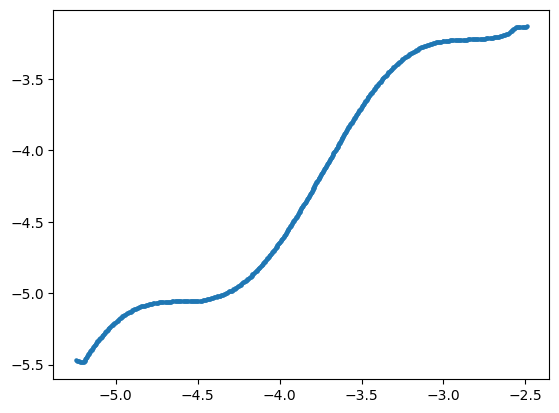

In [89]:
zx = pd.read_csv('out_chart3d/2_xoz_zx.csv')
x = zx['x']
z = zx['z']
plt.scatter(x, z, s=5)

In [90]:
XOZ_PATH = Path("Data/初赛数据-血管造影图像/自建-二维投影曲线图像/3/xoz平面投影.png")
YOZ_PATH = Path("Data/初赛数据-血管造影图像/自建-二维投影曲线图像/3/yoz平面投影.png")
OUT_DIR  = Path("./out_chart3d")

_, roi_xoz, pts_xoz = extract_curve_pixels(XOZ_PATH)
df_xoz = map_pixels_by_ranges(pts_xoz, roi_xoz, plane="xoz",
                              x_range=(-1.51, 1.58), z_range=(-1.41, 1.41))
df_xoz.to_csv(f"{OUT_DIR}/3_xoz_zx.csv", index=False)


_, roi_yoz, pts_yoz = extract_curve_pixels(YOZ_PATH)
df_yoz = map_pixels_by_ranges(pts_yoz, roi_yoz, plane="yoz",
                              y_range=(-1.1, 0.26), z_range=(-1.41, 1.41))
df_yoz.to_csv(f"{OUT_DIR}/3_yoz_zy.csv", index=False)

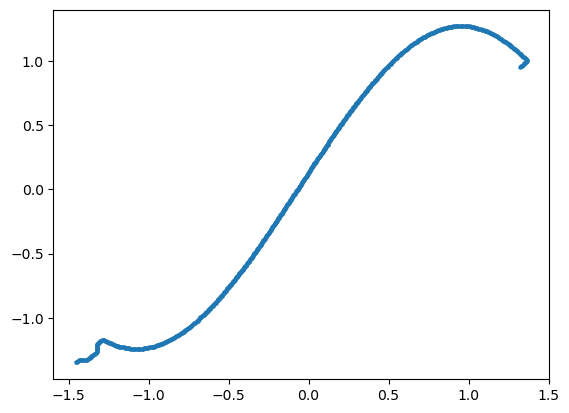

In [91]:
zx = pd.read_csv('out_chart3d/3_xoz_zx.csv')
x = zx['x']
z = zx['z']
plt.scatter(x, z, s=5)

## 2.2 Parameter Fitting

In [32]:
import json
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from scipy.optimize import least_squares
from numpy.fft import rfft, rfftfreq

# ---------------------------
# Utility helpers
# ---------------------------

def read_projection_csv_z_first(path, assume_header=False):
    """
    Reads a CSV where the FIRST column is Z and the SECOND is X or Y.
    Returns an ndarray shaped (N, 2) with columns [value, z] for downstream code.
    Robust to headers; set assume_header if you know there's a header row.
    """
    # Try to read; if header unknown, let pandas guess, then coerce numeric
    df = pd.read_csv(path, header=0 if assume_header else None)
    if df.shape[1] < 2:
        raise ValueError(f"Expected at least 2 columns in {path}")

    # Take first two columns as (Z, V)
    z_raw = pd.to_numeric(df.iloc[:, 0], errors='coerce')
    v_raw = pd.to_numeric(df.iloc[:, 1], errors='coerce')
    mask = z_raw.notna() & v_raw.notna()
    z = z_raw[mask].to_numpy(dtype=float)
    v = v_raw[mask].to_numpy(dtype=float)

    # Return as [value, z] to match the rest of the pipeline
    return np.column_stack([v, z])



def read_projection_csv(path, cols):
    """Read CSV [col0, col1] -> ndarray (N,2). Drops NaNs, sorts by Z if present."""
    df = pd.read_csv(path)
    df = df.dropna()
    if len(cols) != 2:
        raise ValueError("cols must have length 2")
    if not set(cols).issubset(df.columns):
        raise ValueError(f"CSV must contain columns {cols}, got {list(df.columns)}")
    arr = df[cols].to_numpy(dtype=float)  # order supplied: e.g., ['x','z']
    return arr

def dedupe_and_sort_by_column(arr, col_idx):
    """Sort rows by column col_idx; drop duplicate keys keeping first occurrence."""
    order = np.argsort(arr[:, col_idx])
    arr = arr[order]
    # remove exact duplicate z (keeps the first)
    _, idx = np.unique(arr[:, col_idx], return_index=True)
    return arr[np.sort(idx)]

def safe_range(x):
    r = np.max(x) - np.min(x)
    return r if r > 1e-12 else 1.0

def resample_targets_from_projections(xoz, yoz, n_grid=1000):
    """
    Build consistent targets x(t), y(t), z(t) on the same uniform t-grid in [0,1],
    using z as the canonical parameter shared by both projections.
    """
    # xoz = [X, Z]; yoz = [Y, Z]
    xoz = dedupe_and_sort_by_column(xoz, col_idx=1)  # sort by Z
    yoz = dedupe_and_sort_by_column(yoz, col_idx=1)

    Zx = xoz[:, 1]; X = xoz[:, 0]
    Zy = yoz[:, 1]; Y = yoz[:, 0]

    # common Z-range (intersection) so both have valid data
    z_min = max(Zx.min(), Zy.min())
    z_max = min(Zx.max(), Zy.max())
    if z_max - z_min < 1e-6:
        raise ValueError("Insufficient overlapping Z-range between projections.")

    z_grid = np.linspace(z_min, z_max, n_grid)

    # monotone splines for stability
    x_of_z = PchipInterpolator(Zx, X, extrapolate=False)
    y_of_z = PchipInterpolator(Zy, Y, extrapolate=False)

    Xg = x_of_z(z_grid)
    Yg = y_of_z(z_grid)

    # build t in [0,1] from normalized z_grid
    t = (z_grid - z_grid.min()) / (z_grid.max() - z_grid.min())

    # Clean any edge NaNs if PCHIP returned NaN (shouldn't when using intersection)
    mask = np.isfinite(Xg) & np.isfinite(Yg)
    t, z_grid, Xg, Yg = t[mask], z_grid[mask], Xg[mask], Yg[mask]

    return t, Xg, Yg, z_grid

@dataclass
class FitConfig:
    n_grid: int = 1000
    seed: int = 42
    eps_monotone: float = 1e-4     # desired minimal z' >= eps
    monotone_penalty: float = 5.0  # penalty weight for z'(t) < eps
    # frequency bounds (rad per unit t)
    freq_lo: float = 0.0
    freq_hi: float = 20.0 * np.pi
    # amplitude bound factor relative to axis range
    amp_factor: float = 2.0
    # optimization
    max_nfev: int = 20000
    ftol: float = 1e-12
    xtol: float = 1e-12
    gtol: float = 1e-12

def estimate_linear_and_sinusoid_inits(t, target):
    """
    Rough init for slope (m) and sinusoid (A, omega):
    - m from simple LS to target ~ m*t
    - sinusoid amplitude ~ std(residual)
    - angular freq from FFT peak (on detrended residual)
    """
    # slope via least squares of y ~ m t + c (but model has no intercept -> center data)
    t0 = t - t.mean()
    y0 = target - target.mean()
    denom = np.sum(t0**2) + 1e-12
    m = float(np.sum(t0 * y0) / denom)

    resid = target - (m * t + target.mean())
    A = float(np.std(resid))

    # FFT to pick dominant frequency (exclude DC)
    N = len(t)
    # t is uniform linspace; frequency grid corresponds to cycles per unit t
    # Use rfft on zero-mean residual
    r = resid - resid.mean()
    if N >= 32 and np.any(np.abs(r) > 0):
        f = rfftfreq(N, d=(t[1] - t[0]))
        R = np.abs(rfft(r))
        # ignore the DC bin and tiny freqs
        R[0:2] = 0.0
        idx = np.argmax(R)
        cycles_per_t = f[idx]
        omega = 2 * np.pi * cycles_per_t
    else:
        omega = 2.0 * np.pi  # a tame default (1 cycle over [0,1])

    return m, A, omega

def pack_params(a,b,c,d,e,f,g,h,i):
    return np.array([a,b,c,d,e,f,g,h,i], dtype=float)

def unpack_params(theta):
    a,b,c,d,e,f,g,h,i = theta
    return a,b,c,d,e,f,g,h,i

def model_xyz(t, theta):
    a,b,c,d,e,f,g,h,i = unpack_params(theta)
    x = a*t + b*np.sin(c*t)
    y = d*t + e*np.cos(f*t)
    z = g*t + h*np.sin(i*t)
    return x,y,z

def model_dz_dt(t, theta):
    # derivative of z with respect to t
    a,b,c,d,e,f,g,h,i = unpack_params(theta)
    dz = g + h*i*np.cos(i*t)
    return dz

def build_bounds(t, Xg, Yg, Zg, cfg: FitConfig):
    # Scales per axis
    rx, ry, rz = safe_range(Xg), safe_range(Yg), safe_range(Zg)
    # slope bounds chosen to allow 4x the naive slope over [0,1]
    ax = abs((Xg[-1]-Xg[0]))  # approx change over t in [0,1]
    ay = abs((Yg[-1]-Yg[0]))
    az = abs((Zg[-1]-Zg[0]))
    slope_lo_hi = lambda a: (-4*a, 4*a)

    a_lo,a_hi = slope_lo_hi(ax)
    d_lo,d_hi = slope_lo_hi(ay)
    g_lo,g_hi = slope_lo_hi(az)

    # amplitude bounds relative to ranges
    b_lo,b_hi = (-cfg.amp_factor*rx, cfg.amp_factor*rx)
    e_lo,e_hi = (-cfg.amp_factor*ry, cfg.amp_factor*ry)
    h_lo,h_hi = (-cfg.amp_factor*rz, cfg.amp_factor*rz)

    c_lo,c_hi = (cfg.freq_lo, cfg.freq_hi)
    f_lo,f_hi = (cfg.freq_lo, cfg.freq_hi)
    i_lo,i_hi = (cfg.freq_lo, cfg.freq_hi)

    lb = np.array([a_lo,b_lo,c_lo,d_lo,e_lo,f_lo,g_lo,h_lo,i_lo], dtype=float)
    ub = np.array([a_hi,b_hi,c_hi,d_hi,e_hi,f_hi,g_hi,h_hi,i_hi], dtype=float)
    return lb, ub

def auto_axis_weights(Xg, Yg, Zg):
    # inverse variance (stabilize with epsilon)
    vx = np.var(Xg) + 1e-12
    vy = np.var(Yg) + 1e-12
    vz = np.var(Zg) + 1e-12
    wx, wy, wz = 1.0/vx, 1.0/vy, 1.0/vz
    # normalize weights to sum to 3 (optional)
    s = (wx+wy+wz)/3.0
    return wx/s, wy/s, wz/s

def residuals(theta, t, Xg, Yg, Zg, wx, wy, wz, cfg: FitConfig):
    x,y,z = model_xyz(t, theta)
    # core residuals (weighted)
    rx = np.sqrt(wx) * (x - Xg)
    ry = np.sqrt(wy) * (y - Yg)
    rz = np.sqrt(wz) * (z - Zg)

    # monotonicity penalty for z'(t) >= eps
    dz = model_dz_dt(t, theta)
    bad = (dz < cfg.eps_monotone)
    pen = np.zeros_like(dz)
    pen[bad] = (cfg.eps_monotone - dz[bad])
    # scale penalty to be comparable to data residuals
    rpen = np.sqrt(cfg.monotone_penalty) * pen

    return np.concatenate([rx, ry, rz, rpen])

def compute_errors(theta, t, Xg, Yg, Zg):
    x,y,z = model_xyz(t, theta)
    err2 = (x-Xg)**2 + (y-Yg)**2 + (z-Zg)**2
    mse = np.mean(err2)
    rms = np.sqrt(mse)
    # ISE ≈ integral over [0,1] via trapezoid (t is uniform)
    ise = np.trapz(err2, t)
    return rms, ise, (x,y,z)

def format_params(theta):
    # 8 decimal places
    names = ["a","b","c","d","e","f","g","h","i"]
    return {n: float(f"{v:.8f}") for n,v in zip(names, theta)}

def initialize_params(t, Xg, Yg, Zg):
    ax, Axi, cxi = estimate_linear_and_sinusoid_inits(t, Xg)
    dy, Ayi, fyi = estimate_linear_and_sinusoid_inits(t, Yg)
    gz, Azi, izi = estimate_linear_and_sinusoid_inits(t, Zg)

    # tame amplitudes if data are very small
    b0 = float(np.clip(Axi, 0.0, 10.0*safe_range(Xg)))
    e0 = float(np.clip(Ayi, 0.0, 10.0*safe_range(Yg)))
    h0 = float(np.clip(Azi, 0.0, 10.0*safe_range(Zg)))

    theta0 = pack_params(ax, b0, cxi, dy, e0, fyi, gz, h0, izi)
    return theta0

def fit_parametric_3d(xoz_csv, yoz_csv, out_dir, cfg=FitConfig()):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # ---- 1) Load and resample targets
    #xoz = read_projection_csv(xoz_csv, cols=['x','z'])
    #yoz = read_projection_csv(yoz_csv, cols=['y','z'])
    xoz = read_projection_csv_z_first(xoz_csv)  # returns [x, z]
    yoz = read_projection_csv_z_first(yoz_csv)  # returns [y, z]

    t, Xg, Yg, Zg = resample_targets_from_projections(xoz, yoz, n_grid=cfg.n_grid)

    # ---- 2) Build weights and bounds
    wx, wy, wz = auto_axis_weights(Xg, Yg, Zg)
    lb, ub = build_bounds(t, Xg, Yg, Zg, cfg)

    # ---- 3) Initialization
    np.random.seed(cfg.seed)
    theta0 = initialize_params(t, Xg, Yg, Zg)

    # small random jitter to avoid FFT-grid alias traps
    jitter = np.array([0, 0, 0.5*np.pi, 0, 0, 0.5*np.pi, 0, 0, 0.5*np.pi]) * (np.random.rand(9)-0.5)
    theta0 = np.clip(theta0 + jitter, lb, ub)

    # ---- 4) Optimize (joint least-squares)
    res = least_squares(
        residuals, theta0, bounds=(lb,ub),
        args=(t, Xg, Yg, Zg, wx, wy, wz, cfg),
        max_nfev=cfg.max_nfev, ftol=cfg.ftol, xtol=cfg.xtol, gtol=cfg.gtol,
        method='trf', verbose=2
    )
    theta = res.x

    # ---- 5) Evaluate
    rms, ise, (xfit,yfit,zfit) = compute_errors(theta, t, Xg, Yg, Zg)

    # ---- 6) Save outputs
    params_out = {
        "parameters": format_params(theta),
        "rms_error": float(f"{rms:.8f}"),
        "ise": float(f"{ise:.8f}"),
        "note": "RMS is sqrt(mean((dx^2+dy^2+dz^2))); ISE is integral over t in [0,1]"
    }
    with open(out_dir/"fitted_parameters.json", "w") as f:
        json.dump(params_out, f, indent=2)

    # Save the reconstructed 3D curve samples
    df_out = pd.DataFrame({
        "t": t,
        "x_fit": xfit, "y_fit": yfit, "z_fit": zfit,
        "x_target": Xg, "y_target": Yg, "z_target": Zg
    })
    df_out.to_csv(out_dir/"reconstruction_samples.csv", index=False, float_format="%.10f")

    # ---- 7) Plots for QA
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.plot(t, Xg, '.', ms=2, label='x target')
    plt.plot(t, xfit, '-', lw=1.5, label='x fit')
    plt.xlabel('t'); plt.ylabel('x'); plt.title('XOZ projection (x vs t)'); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(t, Yg, '.', ms=2, label='y target')
    plt.plot(t, yfit, '-', lw=1.5, label='y fit')
    plt.xlabel('t'); plt.ylabel('y'); plt.title('YOZ projection (y vs t)'); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(t, Zg, '.', ms=2, label='z target')
    plt.plot(t, zfit, '-', lw=1.5, label='z fit')
    plt.xlabel('t'); plt.ylabel('z'); plt.title('Depth (z vs t)'); plt.legend()

    plt.tight_layout()
    plt.savefig(out_dir/"fit_overlays.png", dpi=180)
    plt.close()

    # 3D scatter (lightweight)
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(xfit, yfit, zfit, lw=1.5)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
    ax.set_title('Reconstructed 3D parametric curve')
    plt.tight_layout()
    plt.savefig(out_dir/"reconstructed_3d.png", dpi=180)
    plt.close()

    return theta, rms, ise


In [33]:


from itertools import product
import time

def _randomize_theta0(theta0, lb, ub, amp_jitter=0.5, freq_jitter=0.5, slope_jitter=0.2, rng=None):
    """
    Jitter the initial params within bounds:
      - slopes (a, d, g): ±slope_jitter relative
      - amplitudes (b, e, h): ±amp_jitter relative
      - freqs (c, f, i): ±freq_jitter relative
    """
    if rng is None:
        rng = np.random.default_rng()
    theta = theta0.copy()
    a,b,c,d,e,f,g,h,i = theta

    rel = lambda v, r: v * (1.0 + r * (rng.random() * 2 - 1))
    a = rel(a, slope_jitter); d = rel(d, slope_jitter); g = rel(g, slope_jitter)
    b = rel(b, amp_jitter);   e = rel(e, amp_jitter);   h = rel(h, amp_jitter)
    c = rel(c, freq_jitter);  f = rel(f, freq_jitter);  i = rel(i, freq_jitter)

    theta = np.array([a,b,c,d,e,f,g,h,i], dtype=float)
    return np.minimum(np.maximum(theta, lb), ub)

def fit_parametric_3d_multistart(
    xoz_csv, yoz_csv, out_dir,
    base_cfg=FitConfig(),
    n_starts=30,
    try_freq_hi=(6*np.pi, 10*np.pi, 20*np.pi),
    try_monopen=(5.0, 20.0),
    verbose=True
):
    """
    Multi-start wrapper:
      - Builds targets/weights once
      - For each (freq_hi, monotone_penalty) combo:
          * build bounds
          * randomize initial theta around a smart seed
          * run least-squares
      - Keep best RMS; save only the best outputs
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # ---------- Precompute targets ----------
    xoz = read_projection_csv_z_first(xoz_csv)  # [x,z]
    yoz = read_projection_csv_z_first(yoz_csv)  # [y,z]
    t, Xg, Yg, Zg = resample_targets_from_projections(xoz, yoz, n_grid=base_cfg.n_grid)
    wx, wy, wz = auto_axis_weights(Xg, Yg, Zg)

    # A base init (used as a center to jitter from)
    theta_seed = initialize_params(t, Xg, Yg, Zg)

    best = None
    best_bundle = None
    run_id = 0
    t0_all = time.time()

    for fh, mp in product(try_freq_hi, try_monopen):
        cfg = FitConfig(**{**base_cfg.__dict__, "freq_hi": float(fh), "monotone_penalty": float(mp)})
        lb, ub = build_bounds(t, Xg, Yg, Zg, cfg)

        for k in range(n_starts):
            run_id += 1
            rng = np.random.default_rng(seed=1000 + run_id)
            theta0 = _randomize_theta0(
                theta_seed, lb, ub,
                amp_jitter=0.8, freq_jitter=0.7, slope_jitter=0.3, rng=rng
            )
            # A tiny direct frequency jitter to escape harmonics
            theta0[[2,5,8]] += rng.normal(0, 0.2*np.pi, size=3)
            theta0 = np.minimum(np.maximum(theta0, lb), ub)

            # Optimize
            res = least_squares(
                residuals, theta0, bounds=(lb,ub),
                args=(t, Xg, Yg, Zg, wx, wy, wz, cfg),
                max_nfev=cfg.max_nfev, ftol=cfg.ftol, xtol=cfg.xtol, gtol=cfg.gtol,
                method='trf', verbose=0
                
            )
            theta = res.x
            rms, ise, (xfit,yfit,zfit) = compute_errors(theta, t, Xg, Yg, Zg)

            if verbose:
                print(f"[{run_id:03d}] freq_hi={fh/np.pi:.1f}π  mono_pen={mp:<5}  "
                      f"RMS={rms:.4f}  ISE={ise:.4f}  nfev={res.nfev}")

            if (best is None) or (rms < best[0]) or (np.isclose(rms, best[0]) and ise < best[1]):
                best = (rms, ise)
                best_bundle = (theta.copy(), cfg, (xfit.copy(), yfit.copy(), zfit.copy()))

    # ---------- Save the best ----------
    theta, cfg_best, (xfit, yfit, zfit) = best_bundle
    rms, ise, _ = compute_errors(theta, t, Xg, Yg, Zg)

    # Save params + metrics (8 dp)
    params_out = {
        "parameters": format_params(theta),
        "rms_error": float(f"{rms:.8f}"),
        "ise": float(f"{ise:.8f}"),
        "notes": {
            "n_starts": n_starts,
            "freq_hi_tried": [float(v) for v in try_freq_hi],
            "monotone_penalty_tried": [float(v) for v in try_monopen],
            "chosen_freq_hi": cfg_best.freq_hi,
            "chosen_monotone_penalty": cfg_best.monotone_penalty,
            "n_grid": cfg_best.n_grid
        }
    }
    with open(out_dir/"fitted_parameters.json", "w") as f:
        json.dump(params_out, f, indent=2)

    # Samples CSV for QA
    df_out = pd.DataFrame({
        "t": t,
        "x_fit": xfit, "y_fit": yfit, "z_fit": zfit,
        "x_target": Xg, "y_target": Yg, "z_target": Zg
    })
    df_out.to_csv(out_dir/"reconstruction_samples.csv", index=False, float_format="%.10f")

    # Plots
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.plot(t, Xg, '.', ms=2); plt.plot(t, xfit, '-', lw=1.5)
    plt.xlabel('t'); plt.ylabel('x'); plt.title('XOZ: x(t)')
    plt.subplot(1,3,2); plt.plot(t, Yg, '.', ms=2); plt.plot(t, yfit, '-', lw=1.5)
    plt.xlabel('t'); plt.ylabel('y'); plt.title('YOZ: y(t)')
    plt.subplot(1,3,3); plt.plot(t, Zg, '.', ms=2); plt.plot(t, zfit, '-', lw=1.5)
    plt.xlabel('t'); plt.ylabel('z'); plt.title('Depth: z(t)')
    plt.tight_layout(); plt.savefig(out_dir/"fit_overlays.png", dpi=180); plt.close()

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(xfit, yfit, zfit, lw=1.5)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
    ax.set_title('Reconstructed 3D parametric curve')
    plt.tight_layout(); plt.savefig(out_dir/"reconstructed_3d.png", dpi=180); plt.close()

    if verbose:
        dt = time.time() - t0_all
        print(f"\nBest RMS={rms:.6f}, ISE={ise:.6f}  |  freq_hi={cfg_best.freq_hi/np.pi:.1f}π, "
              f"mono_pen={cfg_best.monotone_penalty}  |  time ~{dt:.1f}s")
 
    return theta, rms, ise, t, Xg, Yg, Zg

In [72]:
theta_best, rms_best, ise_best, t, Xg, Yg, Zg = fit_parametric_3d_multistart(
    "out_chart3d/1_xoz_zx.csv",
    "out_chart3d/1_yoz_zy.csv",
    "./out_chart3d_fit_multistart_1",
    base_cfg=FitConfig(n_grid=2000, eps_monotone=1e-4, max_nfev=25000),
    n_starts=60,                                # bump up if you want
    try_freq_hi=(6*np.pi, 10*np.pi, 20*np.pi),  # slow → moderate oscillations
    try_monopen=(5.0, 20.0),                    # weak vs. strong monotonicity
    verbose=True
)
print("Best params (a..i):", [f"{v:.8f}" for v in theta_best])
print("RMS:", f"{rms_best:.8f}", "ISE:", f"{ise_best:.8f}")


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_7360\4092450688.py:228: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ise = np.trapz(err2, t)


[001] freq_hi=6.0π  mono_pen=5.0    RMS=1.5259  ISE=2.3283  nfev=58
[002] freq_hi=6.0π  mono_pen=5.0    RMS=1.5409  ISE=2.3741  nfev=78
[003] freq_hi=6.0π  mono_pen=5.0    RMS=1.1739  ISE=1.3776  nfev=29
[004] freq_hi=6.0π  mono_pen=5.0    RMS=1.5195  ISE=2.3087  nfev=40
[005] freq_hi=6.0π  mono_pen=5.0    RMS=1.5394  ISE=2.3695  nfev=60
[006] freq_hi=6.0π  mono_pen=5.0    RMS=1.5329  ISE=2.3496  nfev=32
[007] freq_hi=6.0π  mono_pen=5.0    RMS=1.2082  ISE=1.4594  nfev=38
[008] freq_hi=6.0π  mono_pen=5.0    RMS=1.5259  ISE=2.3283  nfev=41
[009] freq_hi=6.0π  mono_pen=5.0    RMS=1.2082  ISE=1.4594  nfev=48
[010] freq_hi=6.0π  mono_pen=5.0    RMS=1.2081  ISE=1.4590  nfev=52
[011] freq_hi=6.0π  mono_pen=5.0    RMS=1.5407  ISE=2.3738  nfev=49
[012] freq_hi=6.0π  mono_pen=5.0    RMS=1.5409  ISE=2.3741  nfev=61
[013] freq_hi=6.0π  mono_pen=5.0    RMS=1.5409  ISE=2.3741  nfev=52
[014] freq_hi=6.0π  mono_pen=5.0    RMS=1.5409  ISE=2.3741  nfev=76
[015] freq_hi=6.0π  mono_pen=5.0    RMS=1.5252  

In [68]:
try:
    import GPUtil
    GPUtil.showUtilization()
except ImportError:
    print("GPUtil not installed, run: pip install gputil")


GPUtil not installed, run: pip install gputil


In [ ]:
theta_best, rms_best, ise_best, t, Xg, Yg, Zg = fit_parametric_3d_multistart(
    "out_chart3d/2_xoz_zx.csv",
    "out_chart3d/2_yoz_zy.csv",
    "./out_chart3d_fit_multistart_2",
    base_cfg=FitConfig(n_grid=2000, eps_monotone=1e-4, max_nfev=25000),
    n_starts=40,                                # bump up if you want
    try_freq_hi=(6*np.pi, 10*np.pi, 20*np.pi),  # slow → moderate oscillations
    try_monopen=(5.0, 20.0),                    # weak vs. strong monotonicity
    verbose=True
)
print("Best params (a..i):", [f"{v:.8f}" for v in theta_best])
print("RMS:", f"{rms_best:.8f}", "ISE:", f"{ise_best:.8f}")


In [ ]:
theta_best, rms_best, ise_best, t, Xg, Yg, Zg = fit_parametric_3d_multistart(
    "out_chart3d/3_xoz_zx.csv",
    "out_chart3d/3_yoz_zy.csv",
    "./out_chart3d_fit_multistart_3",
    base_cfg=FitConfig(n_grid=2000, eps_monotone=1e-4, max_nfev=25000),
    n_starts=40,                                # bump up if you want
    try_freq_hi=(6*np.pi, 10*np.pi, 20*np.pi),  # slow → moderate oscillations
    try_monopen=(5.0, 20.0),                    # weak vs. strong monotonicity
    verbose=True
)
print("Best params (a..i):", [f"{v:.8f}" for v in theta_best])
print("RMS:", f"{rms_best:.8f}", "ISE:", f"{ise_best:.8f}")


# 3. Centerline Extraction

In [10]:
class DeepSAWrapper:
    """
    Minimal adapter to run DeepSA inference.
    Expect repo at deepsa_root with ckpt/*.ckpt present.
    """
    def __init__(self, deepsa_root: str):
        sys.path.insert(0, deepsa_root)
        try:
            import torch
            from PIL import Image
            import torchvision.transforms as T
        except Exception as e:
            raise RuntimeError(f"DeepSA requires torch/torchvision/Pillow: {e}")
        # Try to import model
        try:
            from models import UNet  # type: ignore
        except Exception as e:
            raise RuntimeError(f"Cannot import DeepSA UNet from {deepsa_root}: {e}")
       # Pick a checkpoint (heuristics)
        ckpt_candidates = [
            os.path.join(deepsa_root, 'ckpt', 'fscad_36249.ckpt'),
            os.path.join(deepsa_root, 'ckpt', 'xcad_4afe3.ckpt'),
            os.path.join(deepsa_root, 'ckpt', 'pt_bc62a.ckpt'),
        ]
        self.ckpt_path = next((p for p in ckpt_candidates if os.path.exists(p)), None)
        if self.ckpt_path is None:
            raise FileNotFoundError("DeepSA checkpoint not found in ckpt/*.ckpt")

        # Build net & load
        self.torch = torch
        self.UNet = UNet
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net = UNet(1, 1, 32, bilinear=True).to(self.device)
        # checkpoints may store just state_dict; try both formats
        ck = torch.load(self.ckpt_path, map_location=self.device)
        state = ck.get('netE', ck)
        if isinstance(state, dict) and any(k.startswith('module.') for k in state.keys()):
            state = {k.replace('module.', ''): v for k,v in state.items()}
        loaded = False
        try:
            self.net.load_state_dict(state)
            loaded = True
        except Exception:
            for key in ['state_dict', 'model', 'model_state', 'model_state_dict']:
                if key in ck:
                    sd = ck[key]
                    if any(k.startswith('module.') for k in sd.keys()):
                        sd = {k.replace('module.', ''): v for k,v in sd.items()}
                    self.net.load_state_dict(sd)
                    loaded = True
                    break
        if not loaded:
            raise RuntimeError("Failed to load DeepSA checkpoint into UNet.")
        self.net.eval()
        self.SIZE = 512
        self.T = T
        self.Image = Image

    '''
    def segment(self, img: np.ndarray):
        """img float32 [0..1] -> (mask{0,1}, prob[0..1]) at original size"""
        H, W = img.shape
        pil = self.Image.fromarray((img*255).astype(np.uint8)).convert('L')
        tf = self.T.Compose([
            self.T.Resize(self.SIZE),
            self.T.ToTensor(),
            self.T.Normalize((0.5,), (0.5,))
        ])
        x = tf(pil)[None].to(self.device)
        with self.torch.no_grad():
            y = self.net(x)
            prob = self.torch.sigmoid(y)[0,0].cpu().numpy()
        prob = cv2.resize(prob, (W, H), interpolation=cv2.INTER_LINEAR)
        # Postproc
        mask = (prob > 0.5).astype(np.uint8)
        mask = binary_closing(mask, disk(2))
        mask = binary_opening(mask, disk(1))
        mask = remove_small_objects(mask, 64)
        mask = (mask>0).astype(np.uint8)
        return mask, prob
    '''
    def segment(self, img01: np.ndarray,
                          auto_thresh: bool = True,
                          options: set = frozenset()):
        """
        Replicates the sample UI's inference & post-processing.
        Returns:
            mask: uint8 {0,1} at original HxW
            prob: float32 [0..1] proxy (from subtraction image) at HxW
        """
        H, W = img01.shape
        pil = self.Image.fromarray((img01*255).astype(np.uint8)).convert('L')

        SIZE = self.SIZE
        tfmc1 = T.Compose([T.Resize(SIZE),
                        T.Lambda(lambda im: tophat(im, 50)),
                        T.ToTensor(),
                        T.Normalize((0.5,), (0.5,))])
        tfmc2 = T.Compose([T.Resize(SIZE),
                        T.ToTensor(),
                        T.Normalize((0.5,), (0.5,))])

        if auto_thresh:
            multiangle = ("Multiangle" in options)
            pad = 50 if ("Pad margin" in options) else 0

            x1, x2 = tfmc1(pil), tfmc2(pil)

            # Two fused predictions (tophat & plain)
            _, out1 = fusion_predict(self.net, ["none"], x1, multiangle=multiangle,
                                    denoise=4, size=SIZE, cutoff=0.4, pad=pad, netE=True)
            _, out2 = fusion_predict(self.net, ["none"], x2, multiangle=False,
                                    denoise=4, size=SIZE, cutoff=0.4, pad=pad, netE=True)

            # Merge by per-pixel max (convert to PIL grayscale)
            arr1, arr2 = np.array(out1), np.array(out2)
            out_merge = np.maximum(arr1, arr2)          # HxW or HxWx1
            if out_merge.ndim == 3:
                out_merge = out_merge.max(axis=2)
            out_merge = Image.fromarray(out_merge.astype(np.uint8)).convert('L')

            # UI gamma tweak
            out_merge = T.functional.adjust_gamma(out_merge, 2.0)

            # UI mask builders
            mask_pil = make_mask(out_merge, remove_size=2000, local_kernel=21, hole_max_size=100)
            mask_pil = clear_mask(mask_pil)  # remove rims/padding etc.

            # Convert to numpy, resize back
            mask = np.array(mask_pil).astype(bool)
            mask = cv2.resize(mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST) > 0

            # Use the subtraction image as a soft proxy "prob"
            sub_img = ImageChops.invert(out_merge)
            sub = np.array(sub_img, dtype=np.float32) / 255.0
            prob = cv2.resize(sub, (W, H), interpolation=cv2.INTER_LINEAR).astype(np.float32)

            return mask.astype(np.uint8), prob

        else:
            # Manual branch from the UI
            x = tfmc1(pil).unsqueeze(0).to(self.device)
            with self.torch.no_grad():
                pred_y = self.net(x)  # shape [1,1,H',W']

            # Deep subtraction image (normalize, denoise, gamma, invert)
            sub = make_grid(pred_y, normalize=True)  # [3,H',W']
            sub = (sub.permute(1,2,0).cpu().numpy() * 255).astype('uint8')
            sub = cv2.fastNlMeansDenoising(sub, None, 3, 7, 21)
            sub = ImageOps.autocontrast(Image.fromarray(sub), cutoff=1)
            sub = T.functional.adjust_gamma(sub, 2.0)
            sub = ImageChops.invert(sub)
            sub = np.array(sub, dtype=np.float32) / 255.0

            # Segmentation via sign of logits (pre-sigmoid) + cleanup
            seg = self.torch.sign(pred_y)
            seg = ((seg.cpu().numpy() + 1) / 2).astype(bool)[0,0]   # H' x W'
            seg = morphology.remove_small_objects(seg, 500)
            mask = cv2.resize(seg.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST) > 0
            prob = cv2.resize(sub, (W, H), interpolation=cv2.INTER_LINEAR).astype(np.float32)
            return mask.astype(np.uint8), prob
        

In [11]:
# dicom_to_projections.py
"""
DICOM angiography → XOZ/YOZ projection centerlines (in mm)
- Vessel enhancement (Frangi), segmentation, skeletonization
- Centerline pruning & longest-path extraction
- Pixel → patient coordinates using DICOM geometry
- Automatic view identification (XOZ vs YOZ) from orientation
- Output CSVs: (z, x) and (z, y) for your existing fitter

Requires: pydicom, numpy, scipy, scikit-image
"""

# -----------------------------
# Utilities
# -----------------------------

def _safe_get(ds: Dataset, name: str, default=None):
    try:
        return getattr(ds, name)
    except Exception:
        return default

def _unit(v: np.ndarray) -> np.ndarray:
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def _orthogonality(a: np.ndarray, b: np.ndarray) -> float:
    """Return |cos(theta)| between two vectors."""
    a, b = _unit(a), _unit(b)
    return float(np.abs(np.dot(a, b)))

def _norm01(a):
    a = a.astype(np.float32)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn + 1e-8:
        return np.zeros_like(a, np.float32)
    return (a - mn) / (mx - mn)

def _smooth_resample_rc(rc, n_out=180, win=21, poly=3):
    rc = np.asarray(rc, np.float32)
    if len(rc) < 5:
        return rc
    # arc-length parameterization
    d = np.sqrt(np.sum(np.diff(rc, axis=0)**2, axis=1))
    s = np.concatenate([[0.0], np.cumsum(d)])
    if s[-1] <= 1e-6:
        return rc
    t = s / s[-1]
    # savgol smooth (guard window)
    win = min(win, len(rc) - (1 - len(rc)%2))  # odd <= len
    win = win if win % 2 == 1 else win - 1
    if win >= 5:
        r = savgol_filter(rc[:,0], win, poly)
        c = savgol_filter(rc[:,1], win, poly)
        rc = np.column_stack([r, c])
    # linear resample
    tt = np.linspace(0, 1, n_out)
    r = np.interp(tt, t, rc[:,0])
    c = np.interp(tt, t, rc[:,1])
    return np.column_stack([r, c]).astype(np.float32)


# -----------------------------
# DICOM geometry
# -----------------------------

@dataclass
class Geometry:
    row_dir: np.ndarray
    col_dir: np.ndarray
    normal: np.ndarray
    ipp: np.ndarray
    spacing: Tuple[float, float]

def _get_shared(ds, seq, key):
    try: return getattr(ds.SharedFunctionalGroupsSequence[0][seq][0], key)
    except Exception: return None

def _get_perframe(ds, k, seq, key):
    try: return getattr(ds.PerFrameFunctionalGroupsSequence[k][seq][0], key)
    except Exception: return None

def get_pixel_spacing(ds, frame_index=None):
    """Return (row_spacing_mm, col_spacing_mm)."""
    sp = None
    if frame_index is not None and hasattr(ds, "PerFrameFunctionalGroupsSequence"):
        sp = _get_perframe(ds, frame_index, "PixelMeasuresSequence", "PixelSpacing")
    if sp is None and hasattr(ds, "SharedFunctionalGroupsSequence"):
        sp = _get_shared(ds, "PixelMeasuresSequence", "PixelSpacing")
    if sp is None:
        sp = getattr(ds, "PixelSpacing", None) or getattr(ds, "ImagerPixelSpacing", None)
    if sp is None or len(sp) != 2:
        raise ValueError("No PixelSpacing/ImagerPixelSpacing found.")
    return float(sp[0]), float(sp[1])  # (row, col)



def extract_geometry(ds: Dataset, frame_index: Optional[int] = None) -> Geometry:
    """
    Extract patient-space geometry for a 2D or multi-frame XA DICOM.
    Tries PerFrameFGS -> SharedFGS -> top-level tags.
    """
    iop = ipp = spacing = None

    # 1) Per-frame
    if frame_index is not None and hasattr(ds, "PerFrameFunctionalGroupsSequence"):
        iop = _get_perframe(ds, frame_index, "PlaneOrientationSequence", "ImageOrientationPatient")
        ipp = _get_perframe(ds, frame_index, "PlanePositionSequence", "ImagePositionPatient")
        spacing = _get_perframe(ds, frame_index, "PixelMeasuresSequence", "PixelSpacing")

    # 2) Shared functional groups
    if iop is None and hasattr(ds, "SharedFunctionalGroupsSequence"):
        iop = _get_shared(ds, "PlaneOrientationSequence", "ImageOrientationPatient")
    if ipp is None and hasattr(ds, "SharedFunctionalGroupsSequence"):
        ipp = _get_shared(ds, "PlanePositionSequence", "ImagePositionPatient")
    if spacing is None and hasattr(ds, "SharedFunctionalGroupsSequence"):
        spacing = _get_shared(ds, "PixelMeasuresSequence", "PixelSpacing")

    # 3) Classic tags
    if iop is None:
        iop = getattr(ds, "ImageOrientationPatient", None)
    if ipp is None:
        ipp = getattr(ds, "ImagePositionPatient", None)
    if spacing is None:
        spacing = getattr(ds, "PixelSpacing", None) or getattr(ds, "ImagerPixelSpacing", None)

    # Validate/normalize
    if iop is None or not hasattr(iop, "__len__") or len(iop) != 6:
        raise ValueError("Missing/invalid ImageOrientationPatient (6 numbers) for this frame/image.")
    iop = [float(x) for x in iop]
    row_dir = _unit(np.array(iop[:3], dtype=float))
    col_dir = _unit(np.array(iop[3:], dtype=float))
    normal  = _unit(np.cross(row_dir, col_dir))

    if ipp is None or not hasattr(ipp, "__len__") or len(ipp) != 3:
        # XA often omits absolute IPP; use origin if absent (keeps relative geometry correct).
        ipp = [0.0, 0.0, 0.0]
    ipp = np.array([float(x) for x in ipp], dtype=float)

    if spacing is None or not hasattr(spacing, "__len__") or len(spacing) != 2:
        raise ValueError("Missing PixelSpacing/ImagerPixelSpacing (2 numbers).")
    spacing = (float(spacing[0]), float(spacing[1]))  # (row, col) mm

    return Geometry(row_dir=row_dir, col_dir=col_dir, normal=normal, ipp=ipp, spacing=spacing)

def pixels_to_patient_xyz(rc_points: np.ndarray, geom: Geometry) -> np.ndarray:
    """
    Convert array of pixel (row, col) -> patient (x,y,z) in mm (DICOM LPS).
    Formula: P = IPP + r*RowDir*RowSpacing + c*ColDir*ColSpacing
    """
    r = rc_points[:, 0].astype(float)
    c = rc_points[:, 1].astype(float)
    P = (geom.ipp
         + np.outer(r, geom.row_dir) * geom.spacing[0]
         + np.outer(c, geom.col_dir) * geom.spacing[1])
    return P  # shape (N, 3) as (x,y,z)


# -----------------------------
# Loading & view selection
# -----------------------------

def _natural_key(p: Path):
    # natural sort: IMG-0001-00001.dcm → numeric aware
    s = p.name
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def load_dicom_pair(patient_folder: str, pair: Optional[Tuple[int, int]] = None) -> Tuple[Dataset, Dataset]:
    """
    Load two DICOMs from patient_folder.

    pair: optional (i, j) 1-based file indices after natural sorting.
          e.g. pair=(4,5) picks the 4th and 5th files exactly.

    If pair is None and there are >2 files, the most-orthogonal pair is chosen.
    """
    files = sorted([p for p in Path(patient_folder).glob("*.dcm") if p.is_file()],
                   key=_natural_key)
    if len(files) < 2:
        raise FileNotFoundError(f"Need at least two DICOMs in {patient_folder}")

    if pair is not None:
        i, j = pair
        if not (1 <= i <= len(files) and 1 <= j <= len(files)):
            raise ValueError(f"pair indices out of range: {pair} for {len(files)} files")
        if i == j:
            raise ValueError("pair indices must be different")
        ds_i = pydicom.dcmread(str(files[i-1]), force=True)
        ds_j = pydicom.dcmread(str(files[j-1]), force=True)
        return ds_i, ds_j

    # default: best-orthogonal pair
    datasets = [pydicom.dcmread(str(p), force=True) for p in files]
    if len(datasets) == 2:
        return datasets[0], datasets[1]

    geoms = [extract_geometry(ds) for ds in datasets]
    best_pair = (0, 1)
    best_score = 1.0
    for a in range(len(geoms)):
        for b in range(a + 1, len(geoms)):
            cos_abs = _orthogonality(geoms[a].normal, geoms[b].normal)
            if cos_abs < best_score:
                best_score = cos_abs
                best_pair = (a, b)
    return datasets[best_pair[0]], datasets[best_pair[1]]

def assign_planes(geom1: Geometry, geom2: Geometry) -> Tuple[str, str]:
    """
    Decide which view is XOZ vs YOZ using the image plane normals.
    LPS axes: x (L→R), y (P→A), z (F→H)
    - If normal ≈ ±y => plane is XOZ (projection along y)
    - If normal ≈ ±x => plane is YOZ (projection along x)
    """
    ex = np.array([1.0, 0.0, 0.0])
    ey = np.array([0.0, 1.0, 0.0])

    scores = []
    for g in [geom1, geom2]:
        ny = float(np.abs(np.dot(g.normal, ey)))
        nx = float(np.abs(np.dot(g.normal, ex)))
        plane = "XOZ" if ny >= nx else "YOZ"
        scores.append(plane)

    # Ensure we have one XOZ and one YOZ; if both same, pick based on larger alignment
    if scores[0] == scores[1]:
        g1, g2 = geom1, geom2
        ny1, nx1 = abs(np.dot(g1.normal, ey)), abs(np.dot(g1.normal, ex))
        ny2, nx2 = abs(np.dot(g2.normal, ey)), abs(np.dot(g2.normal, ex))
        # Choose the one more y-aligned as XOZ, the other as YOZ
        if ny1 - nx1 >= ny2 - nx2:
            return "XOZ", "YOZ"
        else:
            return "YOZ", "XOZ"
    return scores[0], scores[1]


# -----------------------------
# Vessel enhancement & segmentation
# -----------------------------

@dataclass
class SegParams:
    frangi_alpha: float = 0.5
    frangi_beta: float = 0.5
    frangi_gamma: float = 15.0
    frangi_scale_range: Tuple[float, float] = (1.0, 3.0)  # in pixels
    frangi_scale_steps: int = 5
    min_object_area: int = 200
    open_disk_radius: int = 1
    prune_length_px: int = 8
    smooth_window: int = 9
    smooth_poly: int = 3

def _auto_crop_roi01(img01: np.ndarray) -> np.ndarray:
    """Crop out black side panels/text. Works on [0,1] image."""
    m = img01 > 0.05
    from skimage.morphology import remove_small_holes, remove_small_objects, binary_closing, disk
    m = binary_closing(m, footprint=disk(3))
    m = remove_small_objects(m, 5000)
    m = remove_small_holes(m, 5000)
    if m.sum() == 0:
        return img01
    r, c = np.where(m)
    r0, r1 = max(r.min()-2, 0), min(r.max()+2, img01.shape[0])
    c0, c1 = max(c.min()-2, 0), min(c.max()+2, img01.shape[1])
    return img01[r0:r1, c0:c1]

def _detect_fov_bbox(img01: np.ndarray, rim_px: int = 6):
    """Return (r0,r1,c0,c1) of active fluoroscopy FOV; erode a small rim."""
    # Field mask = anything not near-black
    m = img01 > 0.06
    m = binary_closing(m, footprint=disk(3))
    m = remove_small_objects(m, 4000)
    m = remove_small_holes(m, 6000)
    if not m.any():  # fallback: whole image
        H, W = img01.shape[:2]
        return 0, H, 0, W

    r, c = np.where(m)
    r0, r1 = r.min(), r.max()
    c0, c1 = c.min(), c.max()
    # erode a rim to kill borders/overlays
    r0 = max(r0 + rim_px, 0); c0 = max(c0 + rim_px, 0)
    r1 = min(r1 - rim_px + 1, img01.shape[0])
    c1 = min(c1 - rim_px + 1, img01.shape[1])
    if r1 <= r0 or c1 <= c0:  # safety
        H, W = img01.shape[:2]
        r0, r1, c0, c1 = rim_px, H-rim_px, rim_px, W-rim_px
    return r0, r1, c0, c1


def preprocess_for_vessels(img: np.ndarray):
    """
    Normalize to [0,1], auto-crop FOV, CLAHE, light denoise.
    Returns: img_proc, (r0, c0) crop offset
    """
    img = img.astype(np.float32, copy=False)
    img = np.nan_to_num(img)

    # robust normalize
    p1, p99 = np.percentile(img, (1, 99))
    if not np.isfinite(p1) or not np.isfinite(p99) or p99 <= p1:
        p1, p99 = float(img.min()), float(img.max())
    img01 = np.clip((img - p1) / (p99 - p1 + 1e-6), 0, 1)

    # crop FOV and keep offset
    r0, r1, c0, c1 = _detect_fov_bbox(img01, rim_px=8)
    img01 = img01[r0:r1, c0:c1]

    # CLAHE + mild blur
    img_eq = exposure.equalize_adapthist(img01, clip_limit=0.02, nbins=256)
    img_d = gaussian_filter(img_eq, sigma=0.7)
    return img_d, (r0, r1, c0, c1)

def kill_borders(mask: np.ndarray, margin: int = 14) -> np.ndarray:
    H, W = mask.shape
    # zero a safety margin all around
    mask[:margin, :] = False
    mask[-margin:, :] = False
    mask[:, :margin] = False
    mask[:, -margin:] = False
    # drop any CC that still touches the frame
    mask = clear_border(mask)
    # close tiny notches along the rim created by CLAHE/crop
    mask = binary_closing(mask, footprint=disk(1))
    return mask

def segment_vessels(img01: np.ndarray, p: SegParams):
    """
    Vessel enhancement for dark coronaries with robust thresholding.
    Returns (mask, vesselness).
    """
    # vessels are dark → invert before filter
    inv = 1.0 - img01
    sigmas = np.linspace(p.frangi_scale_range[0],
                         p.frangi_scale_range[1],
                         int(p.frangi_scale_steps))

    # Sato/Frangi both work; Sato is very good for thin tubes
    v = sato(inv, sigmas=sigmas, black_ridges=False)
    v = (v - v.min()) / (v.max() - v.min() + 1e-8)

    # thresholds
    hi = np.percentile(v, 98.0)
    lo = np.percentile(v, 92.0)

    # Preferred: morphological reconstruction (grow strong ridges into softer mask)
    seed = (v >= hi).astype(np.uint8)
    soft = (v >= lo).astype(np.uint8)
    mask = reconstruction(seed, soft, method="dilation").astype(bool)

    # Fallback if something goes wrong (or mask is empty): hysteresis
    if mask.sum() == 0:
        mask = apply_hysteresis_threshold(v, lo, hi)

    # Cleanup
    mask = remove_small_objects(mask, min_size=p.min_object_area)
    if p.open_disk_radius > 0:
        mask = binary_opening(mask, footprint=disk(p.open_disk_radius))

    # Kill borders hard
    margin = max(12, int(0.035 * min(img01.shape)))  # ~3.5% of size
    mask = kill_borders(mask, margin=margin)

    return mask, v

def _compute_vesselness(img01: np.ndarray,
                        sigmas=np.linspace(1, 7, 7)) -> np.ndarray:
    """Sato ⊕ Meijering, normalized to [0,1] (vessels bright)."""
    inv = 1.0 - img01
    v1  = sato(inv, sigmas=sigmas, black_ridges=False)
    v2  = meijering(inv, sigmas=sigmas)
    v   = np.maximum(v1, v2)
    v   = (v - v.min()) / (v.max() - v.min() + 1e-8)
    return v.astype(np.float32)

def _connect_on_vesselness(mask: np.ndarray, v: np.ndarray,
                           steps: int = 2, p_lo: float = 88.0) -> np.ndarray:
    """Grow only on reasonably high vesselness to seal pinholes."""
    allow = v >= np.percentile(v, p_lo)
    out = mask.copy()
    for _ in range(max(1, steps)):
        grown = binary_dilation(out, footprint=disk(1)) & allow
        if np.array_equal(grown, out): break
        out = grown
    return out


def segment_tree_mask_fused(
    img01: np.ndarray,
    seg_params: "SegParams",
    deepsa: Optional["DeepSAWrapper"] = None,
) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:

    H, W = img01.shape

    if deepsa is not None:
        # IMPORTANT: call the UI-equivalent function, not the old .segment()
        # "Pad margin" is not needed here and can hurt edge ostia; keep Multiangle.
        mask_ui, prob = deepsa.segment(
            img01, auto_thresh=True, options={"Multiangle", "Pad margin"}
        )
        mask = mask_ui.astype(bool)

        # If DeepSA returned almost nothing, fall back
        if mask.sum() < 1500:  # ~6 px curve x 250 samples
            # --- classical fallback ---
            print('DeepSA returned a mask with', mask.sum(), 'pixels; falling back to classical vesselness.')
            v = _compute_vesselness(img01).astype(np.float32)
            hi, lo = np.percentile(v, (98.0, 92.0))
            seed, soft = (v >= hi), (v >= lo)
            mask_fb = reconstruction(seed.astype(np.uint8), soft.astype(np.uint8),
                                     method="dilation").astype(bool)
            mask_fb = remove_small_objects(mask_fb, 256)
            mask_fb = binary_opening(mask_fb, disk(1))
            w = distance_transform_edt(mask_fb).astype(np.float32)
            w = (w - w.min()) / (w.max() - w.min() + 1e-8)
            return mask_fb, w, {"prob": prob, "vesselness": v}

        print('DeepSA returned a mask with', mask.sum(), 'pixels; using it.')
        # --- keep only the component with the longest skeleton (main trunk) ---
        lab = measure.label(mask, connectivity=2)
        best = np.zeros_like(mask, bool); best_len = -1
        for lbl in range(1, lab.max() + 1):
            comp = (lab == lbl)
            sk = skeletonize(comp)
            ln = int(sk.sum())
            if ln > best_len:
                best_len = ln
                best = comp

        # light connectivity to bridge 1px gaps, do NOT clear_border
        best = binary_closing(best, disk(1))
        best = binary_dilation(best, disk(1))  # ~3px tube

        # distance-transform weight (center highest)
        w = distance_transform_edt(best).astype(np.float32)
        w = (w - w.min()) / (w.max() - w.min() + 1e-8)

        return best, w, {"prob": prob}

    # ---- Classical (no DeepSA) branch --------------------------------------
    print(f'No DeepSA; using classical vesselness for {H}x{W} image.')
    v = _compute_vesselness(img01).astype(np.float32)
    hi, lo = np.percentile(v, (98.0, 92.0))
    seed, soft = (v >= hi), (v >= lo)
    mask = reconstruction(seed.astype(np.uint8), soft.astype(np.uint8),
                          method="dilation").astype(bool)
    mask = remove_small_objects(mask, seg_params.min_object_area)
    mask = binary_opening(mask, disk(seg_params.open_disk_radius or 1))
    w = distance_transform_edt(mask).astype(np.float32)
    w = (w - w.min()) / (w.max() - w.min() + 1e-8)
    return mask, w, {"vesselness": v}



def smooth_polyline_mm(poly: np.ndarray, window: int, polyorder: int) -> np.ndarray:
    """
    Savitzky–Golay smoothing in patient (mm) space to stabilize noisy centerlines.
    """
    if poly.shape[0] < max(window, polyorder + 2):
        return poly
    sm = poly.copy()
    for k in range(3):
        sm[:, k] = savgol_filter(poly[:, k], window_length=window, polyorder=polyorder, mode="interp")
    return sm


# -----------------------------
# High-level centerline extraction from a DICOM
# -----------------------------

'''
def select_frame_index(ds: Dataset, strategy: str = "max_contrast") -> int:
    """
    Choose a frame from a multi-frame XA.
    strategies:
      - "max_contrast": frame with highest std/variance (contrast bolus)
      - "middle": middle frame
      - "first": frame 0
    """
    arr = ds.pixel_array
    if arr.ndim == 2:
        return 0
    # arr shape: (T, H, W)
    if strategy == "first":
        return 0
    if strategy == "middle":
        return int(arr.shape[0] // 2)
    # max_contrast
    # use std (robust enough); could combine with 95th percentile
    stds = arr.reshape(arr.shape[0], -1).std(axis=1)
    return int(np.argmax(stds))
'''

def select_frame_index(ds,
                       fixed_k: Optional[int] = None,
                       step: int = 2,
                       border_margin: int = 18) -> int:
    """
    If `fixed_k` is given -> return that (clipped).
    Else score frames fast with a mix of vesselness, contrast, sharpness,
    and a border penalty. Coarse scan by `step`, then refine ±2 frames.
    """
    arr = ds.pixel_array
    if arr.ndim != 3:
        return 0

    # explicit override (e.g. from 影像数据说明)
    if fixed_k is not None:
        return int(np.clip(fixed_k, 0, arr.shape[0] - 1))

    mono1 = (getattr(ds, "PhotometricInterpretation", "MONOCHROME2") == "MONOCHROME1")
    n = arr.shape[0]

    def _prep(im):
        im = im.astype(np.float32)
        if mono1:
            im = im.max() - im                    # make vessels dark->bright later
        im = cv2.resize(im, (256, 256), interpolation=cv2.INTER_AREA)
        # normalize to [0,1] and light CLAHE
        im01 = im - im.min()
        im01 /= (im01.max() + 1e-8)
        im01 = exposure.equalize_adapthist(im01, clip_limit=0.01)  # light, fast
        return im01

    def _score(im01):
        inv = 1.0 - im01                          # vessels bright for filters
        # very light multi-scale line filter
        v = sato(inv, sigmas=[1.2, 2.0], black_ridges=False)
        v = (v - v.min()) / (v.max() - v.min() + 1e-8)
        vscore = float(np.percentile(v, 99))      # strong ridge presence
        cscore = float(np.percentile(inv, 97) - np.percentile(inv, 5))  # bolus
        # sharpness (focus / motion blur)
        lap = cv2.Laplacian((im01*255).astype(np.uint8), cv2.CV_32F)
        sharp = float(np.log1p(np.var(lap)))
        # border penalty: mean vesselness near frame edges
        m = border_margin
        rim = np.r_[v[:m, :].ravel(), v[-m:, :].ravel(), v[:, :m].ravel(), v[:, -m:].ravel()]
        bpen = float(np.mean(rim))
        # final score
        return 0.55*vscore + 0.25*cscore + 0.25*sharp - 0.20*bpen

    # coarse pass
    ks = list(range(0, n, max(1, step)))
    ims = [_prep(arr[k]) for k in ks]
    scores = np.array([_score(im) for im in ims], dtype=np.float32)

    # light temporal smoothing
    if len(scores) > 3:
        scores = np.convolve(scores, np.array([0.2, 0.6, 0.2], dtype=np.float32), mode="same")

    k_coarse = ks[int(np.argmax(scores))]

    # refine in a tiny neighborhood
    lo = max(0, k_coarse - 2); hi = min(n - 1, k_coarse + 2)
    best_k, best = k_coarse, -1e9
    for k in range(lo, hi + 1):
        s = _score(_prep(arr[k]))
        if s > best:
            best, best_k = s, k

    return int(best_k)



def _safe_spacing(ds: Dataset) -> Tuple[float, float]:
    """(row, col) spacing in mm with fallback to 1.0 mm."""
    sp = getattr(ds, "PixelSpacing", None)
    try:
        if sp is not None and len(sp) >= 2:
            return float(sp[0]), float(sp[1])
    except Exception:
        pass
    return 1.0, 1.0

def debug_save_overlays(view, frame_idx, img01, mask, centerline_rc, out_dir):
    try:
        import matplotlib.pyplot as plt
        from skimage.morphology import skeletonize
        sk = skeletonize(mask)
        plt.figure(figsize=(10,4))
        plt.subplot(1,3,1); plt.imshow(img01, cmap='gray'); plt.title(f'{view} frame {frame_idx} norm+CLAHE'); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(img01, cmap='gray'); plt.imshow(mask, alpha=0.4); plt.title('mask'); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(img01, cmap='gray'); 
        if centerline_rc.size:
            rr, cc = centerline_rc[:,0], centerline_rc[:,1]
            plt.plot(cc, rr, 'y-', lw=1)
        plt.title('chosen path'); plt.axis('off')
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        plt.tight_layout(); plt.savefig(Path(out_dir)/f'{view}_frame{frame_idx:03d}.png', dpi=140)
        plt.close()
    except Exception:
        pass

def extract_centerline_from_mask(mask: np.ndarray, vesselness: np.ndarray,
                                 prune_px: int = 10) -> np.ndarray:
    sk = skeletonize(mask)

    # prune short spurs
    def deg(img, r, c):
        nn = 0
        for dr in (-1,0,1):
            for dc in (-1,0,1):
                if dr==0 and dc==0: continue
                rr, cc = r+dr, c+dc
                if 0<=rr<img.shape[0] and 0<=cc<img.shape[1] and img[rr,cc]:
                    nn += 1
        return nn

    sk_bin = sk.copy()
    for _ in range(40):
        changed = False
        endpoints = [(r, c) for r, c in np.argwhere(sk_bin) if deg(sk_bin, r, c) <= 1]
        for (r0,c0) in endpoints:
            path = [(r0,c0)]
            r,c = r0,c0
            for _ in range(prune_px):
                nbrs = [(rr,cc) for rr in range(r-1,r+2) for cc in range(c-1,c+2)
                        if (rr!=r or cc!=c)
                        and 0<=rr<sk_bin.shape[0] and 0<=cc<sk_bin.shape[1] and sk_bin[rr,cc]]
                if len(nbrs)!=1: break
                r,c = nbrs[0]; path.append((r,c))
            if len(path) <= prune_px:
                for rr,cc in path:
                    if sk_bin[rr,cc]:
                        sk_bin[rr,cc] = False; changed=True
        if not changed: break

    endpoints = [(r, c) for r, c in np.argwhere(sk_bin) if deg(sk_bin, r, c) == 1]
    if len(endpoints) < 2:
        return np.argwhere(sk_bin).astype(float)

    # cost prefers high vesselness and staying on skeleton
    eps = 1e-4
    cost = 1.0 / (vesselness + eps)
    cost[~sk_bin] = cost.max() * 1000.0  # prohibit off-skeleton travel

    best = None
    # score by avg cost and by length; keep top compromise
    for i in range(len(endpoints)):
        for j in range(i+1, len(endpoints)):
            s = tuple(endpoints[i]); e = tuple(endpoints[j])
            try:
                path_rc, path_cost = route_through_array(cost, s, e, fully_connected=True, geometric=True)
            except Exception:
                continue
            path_rc = np.array(path_rc, dtype=float)
            L = len(path_rc)
            if L < 20:     # ignore tiny paths
                continue
            avg_cost = path_cost / max(L,1)
            score = avg_cost  # lower is better
            if best is None or score < best["score"]:
                best = {"path": path_rc, "score": score, "L": L}

    return np.empty((0,2)) if best is None else best["path"]

def _deg(sk, r, c):
    H, W = sk.shape
    return sum(
        1 for dr in (-1,0,1) for dc in (-1,0,1)
        if (dr or dc) and 0 <= r+dr < H and 0 <= c+dc < W and sk[r+dr, c+dc]
    )


def extract_centerline_geodesic(mask, vesselness,
                                border_margin=14, dilate_gap=1,
                                min_len_px=120, alpha_v=0.6, beta_r=0.4):
    """Main trunk = geodesic-diameter path restricted to the connected skeleton."""
    # Clean + allow tiny gaps
    mask = clear_border(mask)
    mask = remove_small_objects(mask, 64)
    allowed = binary_dilation(mask, footprint=disk(dilate_gap)) if dilate_gap > 0 else mask

    # Skeleton inside allowed region
    sk = skeletonize(allowed)

    # Endpoints away from the frame
    H, W = sk.shape
    endpoints = [(int(r), int(c)) for r, c in np.argwhere(sk)
                 if _deg(sk, r, c) == 1 and
                    border_margin <= r < H-border_margin and
                    border_margin <= c < W-border_margin]
    if len(endpoints) < 2:
        pts = np.argwhere(sk)
        return pts.astype(float) if len(pts) else np.empty((0, 2))

    # Connected components of the skeleton
    labels, ncc = ndi.label(sk)
    # group endpoints by component; never route between components
    groups = {}
    for r, c in endpoints:
        lab = labels[r, c]
        if lab:
            groups.setdefault(lab, []).append((r, c))

    # Quality score (vesselness + radius)
    rad   = distance_transform_edt(mask.astype(np.uint8))
    rad_n = rad / (rad.max() + 1e-6)
    score = alpha_v * vesselness + beta_r * rad_n
    score = (score - score.min()) / (score.max() - score.min() + 1e-8)

    eps  = 1e-4
    best = None

    for lab, epset in groups.items():
        if len(epset) < 2:
            continue

        # Cost is infinite outside THIS component -> cannot cross gaps
        sk_lab = (labels == lab)
        cost_lab = np.where(sk_lab, 1.0 / (score + eps), np.inf)

        # helper: route s→e within this component
        def _route(s, e):
            try:
                path_rc, tot_cost = route_through_array(cost_lab, s, e,
                                                        fully_connected=True, geometric=True)
            except Exception:
                return None, 0, np.inf
            path_rc = np.asarray(path_rc, float)
            if not np.isfinite(tot_cost):
                return None, 0, np.inf
            L = len(path_rc)
            return path_rc, L, (tot_cost / max(L, 1))

        # two-pass farthest pair inside component
        # start from endpoint with highest local score
        e0 = max(epset, key=lambda p: score[p])
        B, Lb = e0, 0
        for e in epset:
            p, L, _ = _route(e0, e)
            if L > Lb:
                B, Lb = e, L
        A, La = B, 0
        for e in epset:
            p, L, _ = _route(B, e)
            if L > La:
                A, La = e, L

        # final A↔B route
        p, L, mc = _route(A, B)
        if p is None or L < min_len_px:
            # try all pairs inside the same component
            for i in range(len(epset)):
                for j in range(i+1, len(epset)):
                    q, L2, mc2 = _route(epset[i], epset[j])
                    if q is None or L2 < min_len_px:
                        continue
                    val = mc2 - 0.002 * L2  # favor longer + cheaper
                    if best is None or val < best[0]:
                        best = (val, q)
        else:
            val = mc - 0.002 * L
            if best is None or val < best[0]:
                best = (val, p)

    return np.empty((0, 2)) if best is None else best[1]

def centerline_longest_path(mask: np.ndarray,
                            edge_bias: bool = True,
                            edge_margin: int = 6,
                            n_resample: int = 200) -> np.ndarray:
    """
    Returns the longest skeleton path (rc coords) inside `mask`.
    If edge_bias=True, prefer starts on the image border (ostium).
    """
    sk = skeletonize(mask.astype(bool)).astype(np.uint8)
    if sk.sum() == 0:
        return np.empty((0, 2), np.float32)

    # endpoints = skeleton pixels with exactly 1 neighbor in 8-conn.
    nb = correlate(sk, np.ones((3, 3), np.uint8), mode='constant', cval=0)
    endpoints = np.column_stack(np.where((sk == 1) & (nb == 2)))
    if len(endpoints) < 2:
        return np.empty((0, 2), np.float32)

    H, W = mask.shape
    # Prefer edge endpoints as starts (ostium usually touches border)
    if edge_bias:
        r, c = endpoints[:, 0], endpoints[:, 1]
        on_edge = (r < edge_margin) | (r > H - 1 - edge_margin) | \
                  (c < edge_margin) | (c > W - 1 - edge_margin)
        starts = endpoints[on_edge] if on_edge.any() else endpoints
    else:
        starts = endpoints

    # Cost image: 1 on skeleton, huge elsewhere → geodesic along skeleton
    cost = np.full((H, W), 1e6, np.float32)
    cost[sk > 0] = 1.0

    best_path = None
    best_len  = -1.0  # geodesic length (with geometric=True it’s Euclidean along skel)

    for s in starts:
        s = tuple(s)
        for e in endpoints:
            e = tuple(e)
            if e == s:
                continue
            path, tot_cost = route_through_array(
                cost, s, e, fully_connected=True, geometric=True
            )
            if len(path) == 0:
                continue
            # tot_cost approximates Euclidean length along the skeleton
            if tot_cost > best_len:
                best_len  = float(tot_cost)
                best_path = np.asarray(path, np.float32)

    if best_path is None:
        return np.empty((0, 2), np.float32)

    # Smooth + uniform resample (uses your existing helper)
    return _smooth_resample_rc(best_path, n_out=n_resample)

def centerline_geodesic_main_trunk(
    mask: np.ndarray,
    prob: np.ndarray = None,
    edge_margin: int = 2,          # keep ostium on the frame edge
    bridge_px: int = 5,            # allow crossing tiny gaps
    alpha_radius: float = 0.95,    # follow DT (center) strongly
    beta_prob: float = 0.05,       # use DeepSA prob as a helper
    min_len_px: int = 220,         # reject short local arcs
    n_end_candidates: int = 40,    # try more distal tips
    n_resample: int = 200,         # output points
    gamma_curv: float = 1e-3       # very mild curvature penalty
) -> np.ndarray:
    """
    Main-trunk by geodesic on a cost image that prefers
    large radius (distance transform) and (optionally) high DeepSA probability.
    Returns rc coordinates (float32) in *mask image* space.
    """
    H, W = mask.shape

    # 1) bridge hairline breaks (don’t bloat the tree)
    work = mask.astype(bool)
    if bridge_px > 0:
        work = binary_dilation(work, disk(max(1, bridge_px // 2)))

    # 2) DT ridge & helper probability
    rad  = distance_transform_edt(work).astype(np.float32)
    radn = _norm01(rad)
    prn  = radn if prob is None else _norm01(prob.astype(np.float32))

    # 3) geodesic cost (huge outside mask)
    cost = np.full((H, W), 1e3, np.float32)
    base = alpha_radius * (1.0 - radn) + beta_prob * (1.0 - prn)
    cost[work] = base[work]

    # 4) skeleton endpoints
    sk = skeletonize(work).astype(np.uint8)
    if sk.sum() == 0:
        return np.empty((0, 2), np.float32)
    nb = correlate(sk, np.ones((3, 3), np.uint8), mode='constant', cval=0)
    endpoints = np.column_stack(np.where((sk == 1) & (nb == 2)))
    if len(endpoints) < 2:
        return np.empty((0, 2), np.float32)

    # 5) proximal start near image border, thickest DT
    r, c = endpoints[:, 0], endpoints[:, 1]
    on_edge = (r < edge_margin) | (r > H - 1 - edge_margin) | \
              (c < edge_margin) | (c > W - 1 - edge_margin)
    cand  = endpoints[on_edge] if on_edge.any() else endpoints
    start = tuple(cand[np.argmax(rad[cand[:, 0], cand[:, 1]])])

    # 6) choose many distal candidates (thicker tips first)
    other = np.array([e for e in map(tuple, endpoints) if e != start], dtype=int)
    if other.size == 0:
        return np.empty((0, 2), np.float32)
    order = np.argsort(rad[other[:, 0], other[:, 1]])[::-1]
    other = other[order[:min(n_end_candidates, len(other))]]

    # 7) route and score
    best_path, best_score, best_med_r = None, np.inf, -1.0
    for e in other:
        e = tuple(e)
        path, tot_cost = route_through_array(
            cost, start, e, fully_connected=True, geometric=True
        )
        if len(path) < min_len_px:
            continue
        path = np.asarray(path, np.float32)

        # mild curvature penalty (prevents tight zig-zags)
        curv = 0.0
        if len(path) > 4 and gamma_curv > 0:
            v = np.diff(path[:, ::-1], axis=0)  # (c,r) vectors
            v /= (np.linalg.norm(v, axis=1, keepdims=True) + 1e-8)
            ang = np.arccos(np.clip((v[:-1] * v[1:]).sum(1), -1, 1))
            curv = ang.mean()

        score = tot_cost / max(len(path), 1) + gamma_curv * curv
        med_r = np.median(rad[path[:, 0].astype(int), path[:, 1].astype(int)])
        if (score < best_score - 1e-9) or (abs(score - best_score) < 1e-9 and med_r > best_med_r):
            best_path, best_score, best_med_r = path, score, med_r

    # 8) fallback: pick the longest geodesic if scoring failed
    if best_path is None:
        max_len = 0
        for e in other:
            p, _ = route_through_array(cost, start, tuple(e),
                                       fully_connected=True, geometric=True)
            if len(p) > max_len:
                max_len, best_path = len(p), np.asarray(p, np.float32)
        if best_path is None:
            return np.empty((0, 2), np.float32)

    # 9) smooth + uniform resample
    return _smooth_resample_rc(best_path, n_out=n_resample)



def extract_vessel_centerline(ds: Dataset,
                              seg_params: Optional[SegParams] = None,
                              fixed_frame: Optional[int] = None,
                              debug_dir=None, view_name="view",
                              deepsa: Optional["DeepSAWrapper"] = None) -> np.ndarray:
    if seg_params is None:
        seg_params = SegParams()

    arr = ds.pixel_array
    k = fixed_frame if (arr.ndim == 3 and fixed_frame is not None) else (
        select_frame_index(ds, fixed_frame=fixed_frame) if arr.ndim == 3 else 0)
    img = (arr[k] if arr.ndim == 3 else arr).astype(np.float32)

    # color → gray
    if img.ndim == 3 and img.shape[-1] in (3, 4):
        img = rgb2gray(img[..., :3]).astype(np.float32)
    # MONOCHROME1 invert
    if _safe_get(ds, "PhotometricInterpretation", "MONOCHROME2") == "MONOCHROME1":
        img = np.max(img) - img

    # preprocess + crop to FOV
    out = preprocess_for_vessels(img)
    img_proc = out[0]
    bbox = out[1]
    # Support both (r0,c0) and (r0,r1,c0,c1)
    if len(bbox) == 2:
        r0, c0 = bbox
        r1, c1 = r0 + img_proc.shape[0], c0 + img_proc.shape[1]
    else:
        r0, r1, c0, c1 = bbox

    # segmentation (DeepSA-first; weight is DT if DeepSA present)
    mask, weight, _dbg = segment_tree_mask_fused(img_proc, seg_params, deepsa=deepsa)

    '''
    # main-trunk extraction — prefer center, allow tiny gaps
    centerline_rc = extract_centerline_geodesic(
        mask, weight,
        border_margin=0,
        dilate_gap=3,
        min_len_px=120,
        alpha_v=0.90,
        beta_r=0.10
    )
    '''
    # main-trunk extraction using DT+prob cost; anchored at edge ostium
    prob = _dbg.get("prob") if isinstance(_dbg, dict) else None
    '''
    centerline_rc = centerline_geodesic_main_trunk(
        mask, prob=prob,
        edge_margin=6,
        alpha_radius=0.75,   # DT importance
        beta_prob=0.25,      # DeepSA prob importance (raise if very reliable)
        min_len_px=140,
        n_resample=180
    )
    '''
    centerline_rc = centerline_longest_path(mask, edge_bias=True, edge_margin=6, n_resample=200)


    # fallback if geodesic is short
    if centerline_rc.size < 5 or len(centerline_rc) < 60:
        centerline_rc = extract_centerline_from_mask(
            mask, weight, prune_px=seg_params.prune_length_px
        )

    # map back to original image coords
    if centerline_rc.size:
        centerline_rc[:, 0] += r0
        centerline_rc[:, 1] += c0

    # debug overlay in crop coords
    if debug_dir is not None:
        dbg = _dbg if isinstance(_dbg, dict) else {}
        if centerline_rc.size:
            overlay_rc = centerline_rc.copy()
            overlay_rc[:, 0] -= r0
            overlay_rc[:, 1] -= c0
        else:
            overlay_rc = centerline_rc
        debug_save_overlays(
            view_name, k, img_proc, mask, overlay_rc, debug_dir,
            extra={"prob": dbg.get("prob"), "vesselness": dbg.get("vesselness")}
        )

    return centerline_rc
# -----------------------------
# Projection conversion & alignment
# -----------------------------

def _monotone_z_from_rows(rows, row_spacing_mm, sign=+1, smooth_win=9, poly=3):
    r = rows.astype(float)
    # light smoothing so tiny up/down noise doesn’t create z jitter
    if smooth_win >= 3 and len(r) >= smooth_win and smooth_win % 2 == 1:
        r = savgol_filter(r, smooth_win, poly, mode="interp")
    # only count forward motion along the chosen sign
    dr = np.diff(r, prepend=r[0])
    forward = np.maximum(0.0, sign * dr)          # clip backward steps to 0
    z = np.cumsum(forward) * float(row_spacing_mm)  # mm
    return z

def to_projections_mm(
    centerline1_rc: np.ndarray, centerline2_rc: np.ndarray,
    ds1: Dataset, ds2: Dataset,
    smooth_params: Tuple[int, int] = (9, 3)
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert two pixel-space centerlines to patient-space (mm) and return:
      xoz_points: [[x,z], ...],  yoz_points: [[y,z], ...]
    Ensures common overlapping z-range, sorted by z ascending, deduplicated.
    """
    g1, g2 = extract_geometry(ds1), extract_geometry(ds2)
    plane1, plane2 = assign_planes(g1, g2)

    # Convert to patient coordinates (x,y,z) in mm
    xyz1 = pixels_to_patient_xyz(centerline1_rc, g1)
    xyz2 = pixels_to_patient_xyz(centerline2_rc, g2)

    # Smooth in mm to tame staircasing from skeletons
    xyz1 = smooth_polyline_mm(xyz1, window=smooth_params[0], polyorder=smooth_params[1])
    xyz2 = smooth_polyline_mm(xyz2, window=smooth_params[0], polyorder=smooth_params[1])

    # Determine projections
    if plane1 == "XOZ":
        xoz = xyz1[:, [0, 2]]  # (x, z)
        yoz = xyz2[:, [1, 2]]  # (y, z)
    else:
        xoz = xyz2[:, [0, 2]]
        yoz = xyz1[:, [1, 2]]

    # We need output as [[x,z]] and [[y,z]] BUT your fitter expects CSV columns (z, x/y).
    # We'll re-order when writing CSV; internally keep (x,z) and (y,z) for clarity.

    # Align to common z-range
    def sort_and_clip(points_xz: np.ndarray) -> np.ndarray:
        # points_xz: (N, 2) as (x_or_y, z)
        arr = points_xz.copy()
        # Ensure shape (N,2) with columns [value, z]
        # Sort by z
        arr = arr[np.argsort(arr[:, 1])]
        # Deduplicate z (keep first)
        z_round = np.round(arr[:,1] / 0.05) * 0.05
        _, idx = np.unique(z_round, return_index=True)
        arr = arr[np.sort(idx)]
        return arr  # (value, z) sorted by z

    xoz = sort_and_clip(xoz)
    yoz = sort_and_clip(yoz)

    # Clip to overlapping z-range
    z1 = xoz[:, 1]
    z2 = yoz[:, 1]
    z_min = max(z1.min(), z2.min())
    z_max = min(z1.max(), z2.max())
    def clip_to_range(arr):
        mask = (arr[:, 1] >= z_min) & (arr[:, 1] <= z_max)
        return arr[mask]

    xoz = clip_to_range(xoz)
    yoz = clip_to_range(yoz)

    # Make sure ascending z
    if xoz.shape[0] >= 2 and xoz[-1, 1] < xoz[0, 1]:
        xoz = xoz[::-1]
    if yoz.shape[0] >= 2 and yoz[-1, 1] < yoz[0, 1]:
        yoz = yoz[::-1]

    return xoz, yoz  # columns are (x,z) and (y,z)

def to_projections_mm_fallback(centerline1_rc, centerline2_rc, sp1, sp2,
                               planes=("XOZ","YOZ"),
                               flips=((+1,+1),(+1,+1))):
    (r1s, c1s), (r2s, c2s) = sp1, sp2
    (s1r, s1c), (s2r, s2c) = flips

    # value coords in mm (x or y, depending on plane assignment)
    v1 = centerline1_rc[:,1].astype(float) * c1s * s1c
    v2 = centerline2_rc[:,1].astype(float) * c2s * s2c

    # z built along path (monotone, mm)
    z1 = _monotone_z_from_rows(centerline1_rc[:,0], r1s, sign=s1r)
    z2 = _monotone_z_from_rows(centerline2_rc[:,0], r2s, sign=s2r)

    # align ranges so both use a common z scale
    z1_min, z1_max = float(z1.min()), float(z1.max())
    z2_min, z2_max = float(z2.min()), float(z2.max())
    if z2_max > z2_min + 1e-6:
        z2 = (z2 - z2_min) * (z1_max - z1_min) / (z2_max - z2_min + 1e-8) + z1_min

    # common z grid (monotone)
    z_lo = max(z1.min(), z2.min())
    z_hi = min(z1.max(), z2.max())
    n = max(40, min(len(z1), len(z2)))  # keep enough samples
    z_common = np.linspace(z_lo, z_hi, n)

    # interpolate value coords onto the common z grid
    x_or_y1 = np.interp(z_common, z1, v1)
    x_or_y2 = np.interp(z_common, z2, v2)

    # assign to XOZ/YOZ explicitly
    if planes[0].upper() == "XOZ" and planes[1].upper() == "YOZ":
        xoz = np.column_stack([z_common, x_or_y1])
        yoz = np.column_stack([z_common, x_or_y2])
    elif planes[0].upper() == "YOZ" and planes[1].upper() == "XOZ":
        xoz = np.column_stack([z_common, x_or_y2])
        yoz = np.column_stack([z_common, x_or_y1])
    else:
        raise ValueError("planes must be a permutation of ('XOZ','YOZ').")

    # ensure strictly increasing z (just in case)
    m = np.diff(xoz[:,0]) > 1e-9
    xoz = xoz[np.r_[True, m]]
    m = np.diff(yoz[:,0]) > 1e-9
    yoz = yoz[np.r_[True, m]]

    return xoz, yoz

def rc_path_to_projection_mm(path_rc_full, ds, z_mode="row", flips=(+1,+1)):
    if path_rc_full is None or path_rc_full.size == 0:
        return np.empty((0, 2), float)

    path_rc_full = path_rc_full.astype(float)
    dr, dc = _safe_spacing(ds)

    r_mm = path_rc_full[:, 0] * dr
    c_mm = path_rc_full[:, 1] * dc

    if z_mode == "arc":
        diffs = np.diff(np.c_[r_mm, c_mm], axis=0)
        seglen = np.sqrt((diffs**2).sum(axis=1))
        z_mm = np.concatenate([[0.0], np.cumsum(seglen)])   # monotone already
    else:  # "row"
        z_mm = r_mm

    z_mm = flips[0] * z_mm
    val  = flips[1] * c_mm

    # Only sort when using "row" z; keep original order for "arc"
    if z_mode == "row":
        order = np.argsort(z_mm)
        z_mm, val = z_mm[order], val[order]

    return np.column_stack([z_mm, val])




# -----------------------------
# I/O helpers (CSV in your expected format)
# -----------------------------

def save_projection_csv(xoz: np.ndarray, yoz: np.ndarray, out_dir: str,
                        xoz_name: str = "xoz.csv", yoz_name: str = "yoz.csv") -> Tuple[Path, Path]:
    """
    Save CSVs as required by your fitter:
    - XOZ CSV columns: z, x
    - YOZ CSV columns: z, y
    """
    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)
    xoz_path = out / xoz_name
    yoz_path = out / yoz_name

    # xoz (x,z) -> write (z,x)
    with open(xoz_path, "w", newline="") as f:
        w = csv.writer(f)
        for val, z in xoz:
            w.writerow([f"{z:.6f}", f"{val:.6f}"])

    # yoz (y,z) -> write (z,y)
    with open(yoz_path, "w", newline="") as f:
        w = csv.writer(f)
        for val, z in yoz:
            w.writerow([f"{z:.6f}", f"{val:.6f}"])

    return xoz_path, yoz_path


# -----------------------------
# Public API you asked for
# -----------------------------
def process_patient_dicoms(patient_folder: str,
                           seg_params: Optional["SegParams"] = None,
                           save_dir: Optional[str] = None,
                           pair: Optional[Tuple[int, int]] = None,
                           planes: Tuple[str, str] = ("XOZ", "YOZ"),
                           flips: Tuple[Tuple[int, int], Tuple[int, int]] = ((+1, +1), (+1, +1)),
                           fixed_frames: Optional[Tuple[int, int]] = None,
                           deepsa: Optional["DeepSAWrapper"] = None,
                           debug_dir: Optional[str] = None
                           ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
        xoz: array [[z_mm, x_mm], ...]
        yoz: array [[z_mm, y_mm], ...]
    Side effect:
        if save_dir is provided -> writes {save_dir}/xoz.csv and {save_dir}/yoz.csv
    """
    # 1) Load the two views
    ds1, ds2 = load_dicom_pair(patient_folder, pair=pair)

    # 2) Choose frames
    if fixed_frames is not None:
        k1 = int(np.clip(fixed_frames[0], 0, (ds1.pixel_array.shape[0]-1) if ds1.pixel_array.ndim==3 else 0))
        k2 = int(np.clip(fixed_frames[1], 0, (ds2.pixel_array.shape[0]-1) if ds2.pixel_array.ndim==3 else 0))
    else:
        k1 = select_frame_index(ds1) if ds1.pixel_array.ndim==3 else 0
        k2 = select_frame_index(ds2) if ds2.pixel_array.ndim==3 else 0

    # 3) Centerlines (pixel coords r,c in original image space)
    cl1 = extract_vessel_centerline(ds1, seg_params,
                                    fixed_frame=k1, debug_dir=debug_dir,
                                    view_name="view1", deepsa=deepsa)
    cl2 = extract_vessel_centerline(ds2, seg_params,
                                    fixed_frame=k2, debug_dir=debug_dir,
                                    view_name="view2", deepsa=deepsa)
    if cl1.shape[0] < 5 or cl2.shape[0] < 5:
        raise ValueError("Centerline extraction failed (too few points).")

    # 4) Pixel→mm fallback (monotone-z along path). This matches your CSV spec (z first).
    sp1 = _safe_spacing(ds1)  # (row_mm, col_mm)
    sp2 = _safe_spacing(ds2)
    print(f'end= {ds1.SOPInstanceUID} spacing: {sp1}, {ds2.SOPInstanceUID} spacing: {sp2}')
    #xoz, yoz = to_projections_mm_fallback(cl1, cl2, sp1, sp2, planes=planes, flips=flips)

    p1 = rc_path_to_projection_mm(cl1, ds1, z_mode="raw", flips=flips[0])
    p2 = rc_path_to_projection_mm(cl2, ds2, z_mode="raw", flips=flips[1])

    # Assign to XOZ / YOZ by the planes tuple
    if planes[0].upper() == "XOZ" and planes[1].upper() == "YOZ":
        xoz, yoz = p1, p2
    elif planes[0].upper() == "YOZ" and planes[1].upper() == "XOZ":
        xoz, yoz = p2, p1
    else:
        raise ValueError("planes must be a permutation of ('XOZ','YOZ').")

    # 5) Save CSVs if requested (NO header; z first col)
    if save_dir is not None:
        out_dir = Path(save_dir)
        out_dir.mkdir(parents=True, exist_ok=True)
        xoz_path = out_dir / "xoz.csv"
        yoz_path = out_dir / "yoz.csv"
        with open(xoz_path, "w", newline="") as f:
            w = csv.writer(f)
            for z, x in xoz:
                w.writerow([f"{z:.6f}", f"{x:.6f}"])
        with open(yoz_path, "w", newline="") as f:
            w = csv.writer(f)
            for z, y in yoz:
                w.writerow([f"{z:.6f}", f"{y:.6f}"])
        print(f"CSV written: {xoz_path} and {yoz_path}")

    return xoz, yoz


In [12]:
# --- single overlay helper -----------------------
def _path_overlay(img_proc, path_rc_crop, title, save_path: Optional[str] = None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img_proc, cmap="gray")
    if path_rc_crop.size:
        ax.plot(path_rc_crop[:, 1], path_rc_crop[:, 0], "-y", lw=2)  # (c,r)
    ax.set_title(title); ax.axis("off")
    if save_path:
        sp = Path(save_path)
        sp.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(sp, dpi=220, bbox_inches="tight", pad_inches=0)
    plt.show()

# ---- 1) Small plotting utilities -------------------------------------------
def _triptych(img_proc, mask, path_rc_crop, title):
    """Show: image, mask overlay, chosen path overlay (all in CROP coords)."""
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    ax[0].imshow(img_proc, cmap="gray")
    ax[0].set_title(f"{title} • norm+CLAHE"); ax[0].axis("off")

    ax[1].imshow(img_proc, cmap="gray")
    ax[1].imshow(mask, cmap=cm.magma, alpha=0.45)
    ax[1].set_title("mask"); ax[1].axis("off")

    ax[2].imshow(img_proc, cmap="gray")
    if path_rc_crop.size:
        ax[2].plot(path_rc_crop[:,1], path_rc_crop[:,0], "-y", lw=2)  # (c,r)
    ax[2].set_title("chosen path"); ax[2].axis("off")
    plt.tight_layout(); plt.show()

def _plot_xoz_yoz(xoz_points, yoz_points, save_dir: Optional[str] = None):
    """Plot XOZ and YOZ curves; optional quick 3D sanity curve."""
    xoz = np.asarray(xoz_points); yoz = np.asarray(yoz_points)
    z_x, x = xoz[:,0], xoz[:,1]
    z_y, y = yoz[:,0], yoz[:,1]

    fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=False)
    ax[0].plot(z_x, x, "-o", ms=2); ax[0].set_title("XOZ")
    ax[0].set_xlabel("z (mm)"); ax[0].set_ylabel("x (mm)"); ax[0].grid(alpha=0.3)
    ax[1].plot(z_y, y, "-o", ms=2, color="C1"); ax[1].set_title("YOZ")
    ax[1].set_xlabel("z (mm)"); ax[1].set_ylabel("y (mm)"); ax[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    if save_dir:
        out_dir = Path(save_dir); out_dir.mkdir(parents=True, exist_ok=True)

        # XOZ
        fig_xoz, ax_x = plt.subplots(figsize=(6, 4))
        ax_x.plot(z_x, x, "-o", ms=2)
        ax_x.set_title("XOZ"); ax_x.set_xlabel("z (mm)"); ax_x.set_ylabel("x (mm)")
        ax_x.grid(alpha=0.3); plt.tight_layout()
        fig_xoz.savefig(out_dir / "xoz.png", dpi=220, bbox_inches="tight", pad_inches=0)
        plt.show()

        # YOZ
        fig_yoz, ax_y = plt.subplots(figsize=(6, 4))
        ax_y.plot(z_y, y, "-o", ms=2, color="C1")
        ax_y.set_title("YOZ"); ax_y.set_xlabel("z (mm)"); ax_y.set_ylabel("y (mm)")
        ax_y.grid(alpha=0.3); plt.tight_layout()
        fig_yoz.savefig(out_dir / "yoz.png", dpi=220, bbox_inches="tight", pad_inches=0)
        plt.show()

    


# ---- 2) One-stop visualizer --------------------------------------------------
def visualize_full_results(patient_folder: str,
                           pair: Tuple[int,int],
                           planes: Tuple[str,str],
                           deepsa=None,
                           fixed_frames: Optional[Tuple[int, int]] = None,
                           seg_params: Optional[SegParams] = None,
                           save_dir: Optional[str] = None):
    """
    Runs your pipeline (so CSVs are produced) and renders:
    - View1 triptych (img, mask, chosen path)
    - View2 triptych
    - XOZ/YOZ plots (+ optional 3D sanity curve)
    """
    # 0) run your existing pipeline to get projection points (and optional CSVs)
    xoz_points, yoz_points = process_patient_dicoms(
        patient_folder,
        seg_params=seg_params,
        fixed_frames=fixed_frames,
        planes=planes,
        pair=pair,
        save_dir=save_dir,
        deepsa=deepsa,
        debug_dir=None  # images will be displayed live below
    )

    # 1) Recompute visuals for each view (same steps as your extractor)
    ds1, ds2 = load_dicom_pair(patient_folder, pair=pair)
    for i, (ds, view_name) in enumerate(zip((ds1,ds2), ("view1","view2"))):
        arr = ds.pixel_array
        if fixed_frames is not None:
            k = select_frame_index(ds, fixed_k=fixed_frames[i]) if arr.ndim == 3 else 0
        else:
            k = select_frame_index(ds) if arr.ndim == 3 else 0
        img = (arr[k] if arr.ndim == 3 else arr).astype(np.float32)

        # color->gray and invert if MONOCHROME1
        if img.ndim == 3 and img.shape[-1] in (3,4):
            img = rgb2gray(img[...,:3]).astype(np.float32)
        if _safe_get(ds, "PhotometricInterpretation", "MONOCHROME2") == "MONOCHROME1":
            img = np.max(img) - img

        # preprocess (CLAHE etc.) + crop
        out = preprocess_for_vessels(img)
        img_proc, bbox = out[0], out[1]
        if len(bbox) == 2:
            r0, c0 = bbox
        else:
            r0, _, c0, _ = bbox

        # fused segmentation (DeepSA first); weight is DT if DeepSA present
        mask, weight, dbg = segment_tree_mask_fused(img_proc, seg_params, deepsa=deepsa)
        prob = dbg.get("prob") if isinstance(dbg, dict) else None

        # main trunk by geodesic (DT + DeepSA prob), anchored at ostium
        '''
        path_rc = centerline_geodesic_main_trunk(
            mask, prob=prob,
            edge_margin=2,
            alpha_radius=0.95,   # DT importance
            beta_prob=0.15,      # DeepSA prob importance
            min_len_px=220,
            n_resample=200,
            n_end_candidates=40,
        )
        '''

        # main trunk by longest path on skeleton (edge-biased, resampled)
        path_rc = centerline_longest_path(mask, edge_bias=True, edge_margin=6, n_resample=200)
        if path_rc.size < 5 or len(path_rc) < 60:
            path_rc = extract_centerline_from_mask(mask, weight, prune_px=(seg_params or SegParams()).prune_length_px)

        # show in CROP coords
                # show triptych
        _triptych(img_proc, mask, path_rc, f"{view_name} frame {k} norm+CLAHE")

        # save overlay per view
        if save_dir:
            _path_overlay(
                img_proc, path_rc,
                title=f"{view_name} overlay",
                save_path=str(Path(save_dir) / f"{view_name}_overlay.png")
            )

    # save XOZ/YOZ plots into the same folder
    _plot_xoz_yoz(xoz_points, yoz_points, save_dir=save_dir)

    return xoz_points, yoz_points

In [14]:
from pydicom.dataset import Dataset
from scipy.ndimage import gaussian_filter, distance_transform_edt, correlate
from scipy import ndimage as ndi
from scipy.signal import savgol_filter
from skimage import exposure, filters, morphology, measure, util
from skimage.morphology import binary_dilation, reconstruction, skeletonize, remove_small_holes, remove_small_objects, binary_closing, binary_opening, disk
from skimage.filters import threshold_otsu, frangi, sato, apply_hysteresis_threshold, meijering, sobel
import cv2
from skimage.segmentation import clear_border
from skimage.graph import route_through_array
from matplotlib import cm
import matplotlib.pyplot as plt
import csv
import torchvision.transforms as T
from torchvision.utils import make_grid
from PIL import Image, ImageOps, ImageChops


DeepSA returned a mask with 12933 pixels; using it.
DeepSA returned a mask with 13096 pixels; using it.
end= 1.3.12.2.1107.5.4.5.100021.30000023041123120795000008847.512 spacing: (1.0, 1.0), 1.3.12.2.1107.5.4.5.100021.30000023041123120795000008839.512 spacing: (1.0, 1.0)
CSV written: patient_1_results\xoz.csv and patient_1_results\yoz.csv
DeepSA returned a mask with 12933 pixels; using it.


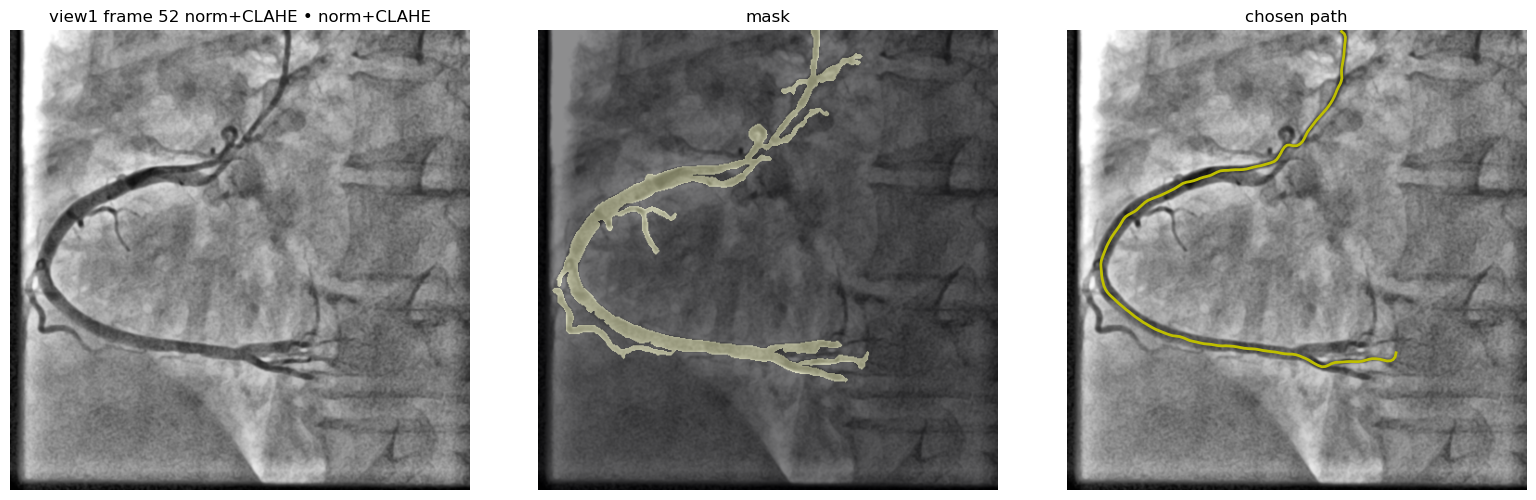

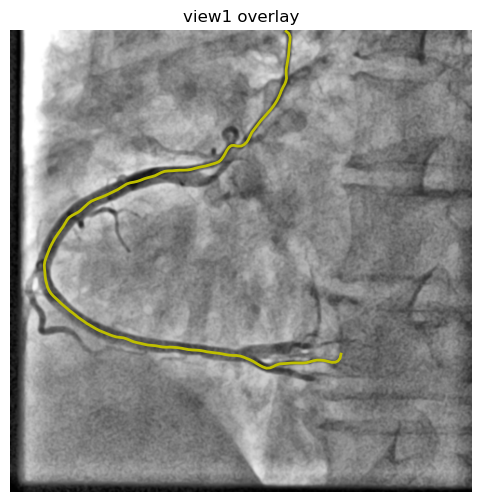

DeepSA returned a mask with 13096 pixels; using it.


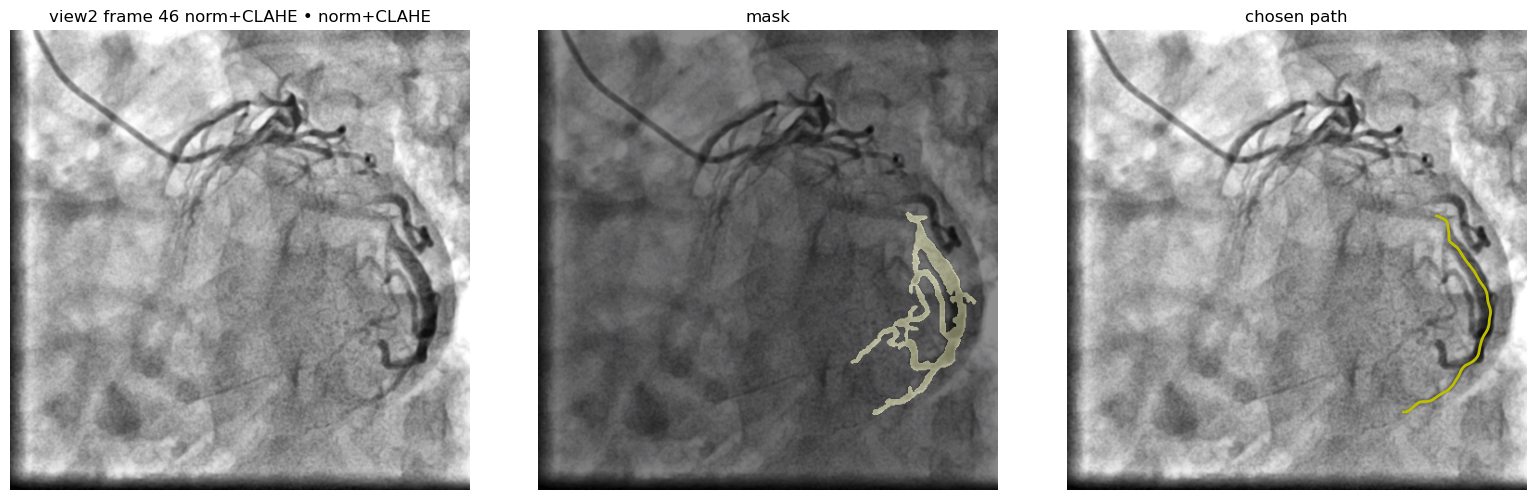

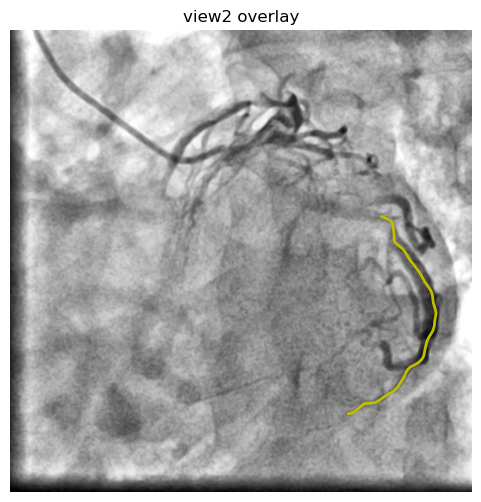

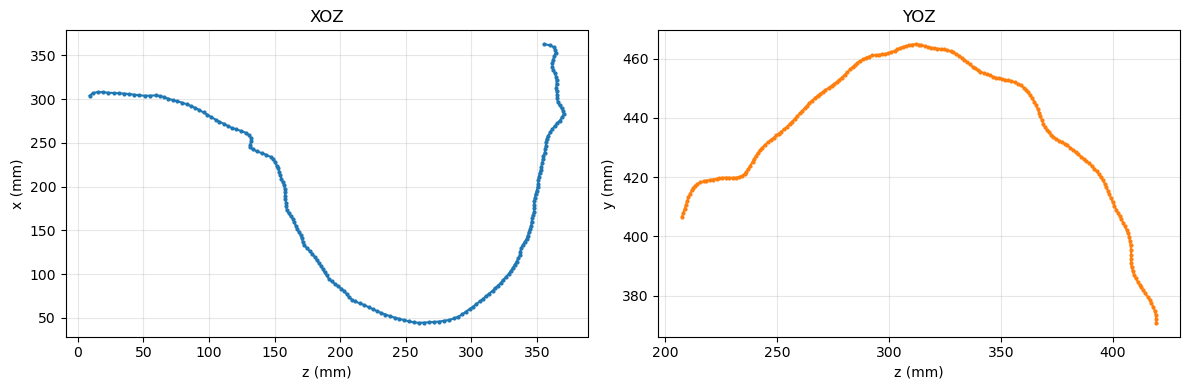

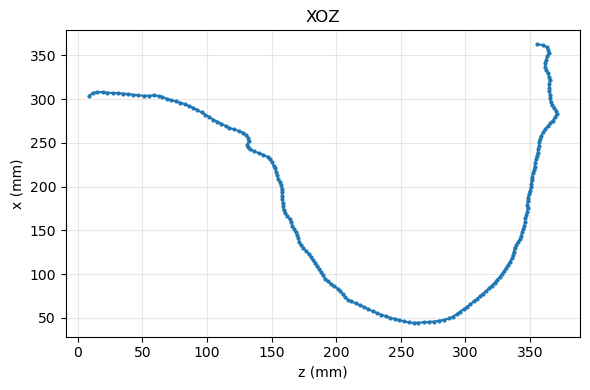

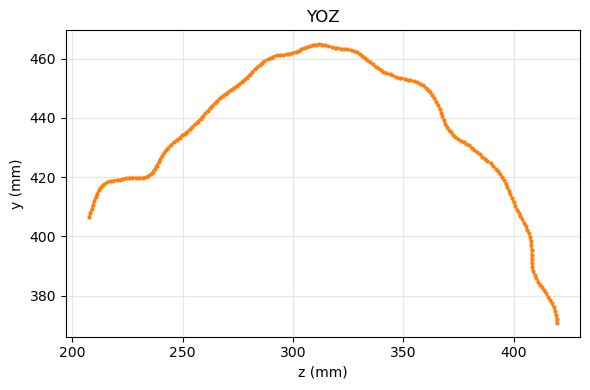

In [15]:
deepsa = DeepSAWrapper("DeepSA")

# View #5 is XOZ, #4 is YOZ in your case
xoz_pts, yoz_pts = visualize_full_results(
    patient_folder="Data/初赛数据-血管造影图像/患者1-血管造影图像",
    pair=(5,4),
    planes=("XOZ","YOZ"),
    deepsa=deepsa,
    #fixed_frames=(41, 44), 
    save_dir="patient_1_results",   # optional: writes xoz.csv / yoz.csv                # optional: quick 3D sanity line
)

DeepSA returned a mask with 15513 pixels; using it.
DeepSA returned a mask with 17956 pixels; using it.
end= 1.3.12.2.1107.5.4.5.100021.30000023041123120795000002248.512 spacing: (1.0, 1.0), 1.3.12.2.1107.5.4.5.100021.30000023041123120795000002245.512 spacing: (1.0, 1.0)
CSV written: patient_2_results\xoz.csv and patient_2_results\yoz.csv
DeepSA returned a mask with 15513 pixels; using it.


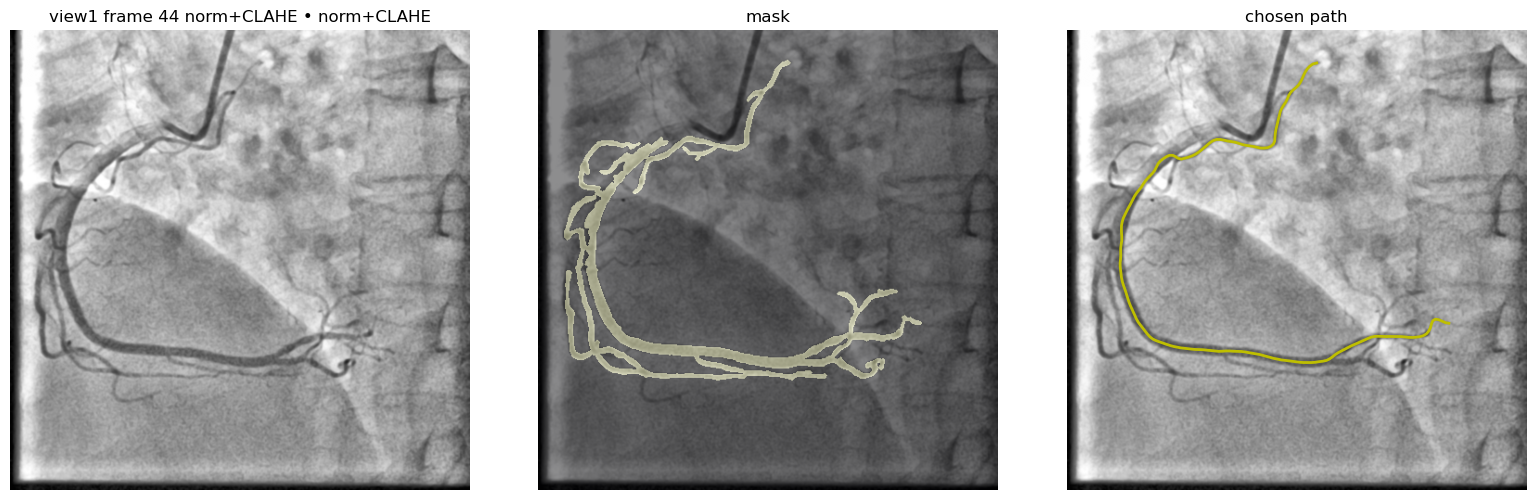

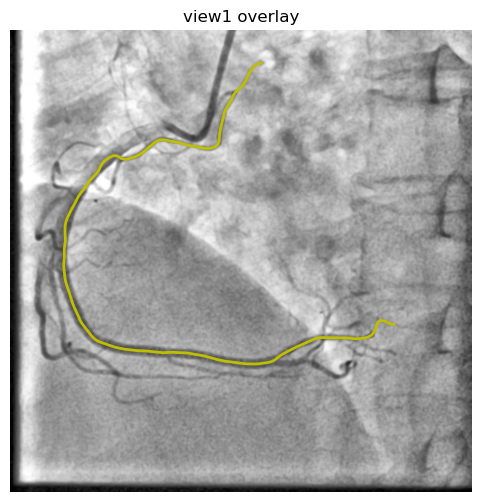

DeepSA returned a mask with 17956 pixels; using it.


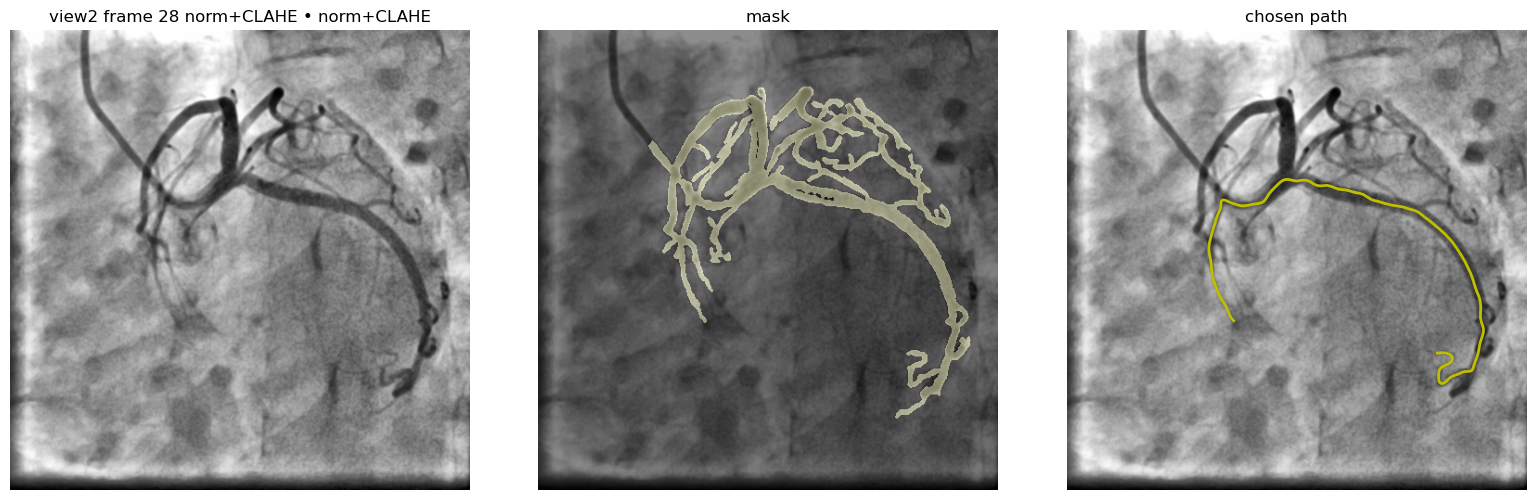

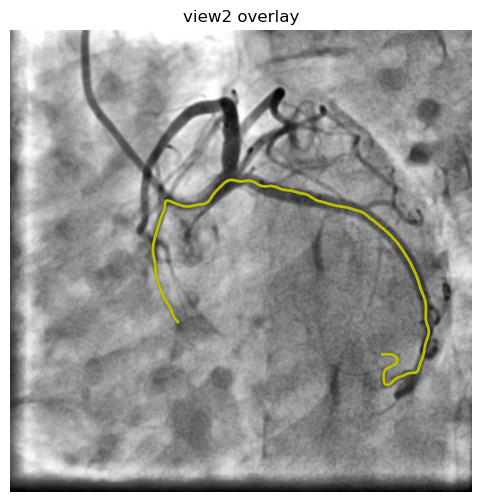

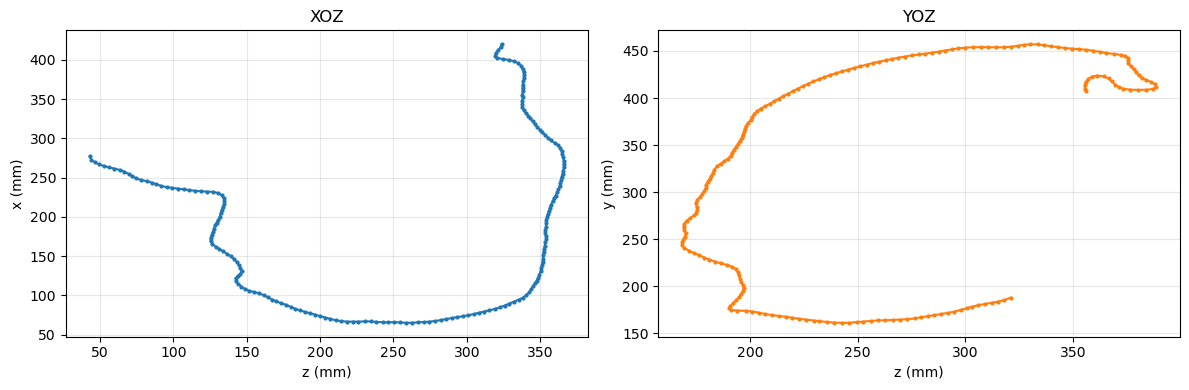

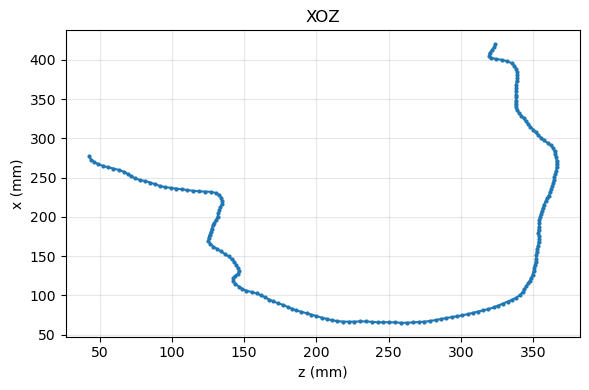

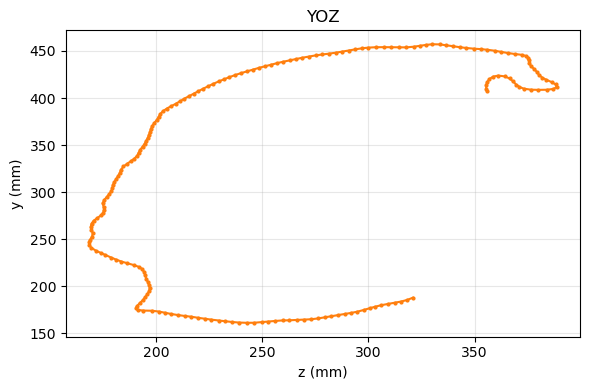

In [16]:
deepsa = DeepSAWrapper("DeepSA")

# View #5 is XOZ, #4 is YOZ in your case
xoz_pts, yoz_pts = visualize_full_results(
    patient_folder="Data/初赛数据-血管造影图像/患者2-血管造影图像",
    pair=(5,4),
    planes=("XOZ","YOZ"),
    deepsa=deepsa,
    #fixed_frames=(41, 44), 
    save_dir="patient_2_results"           
)

DeepSA returned a mask with 6809 pixels; using it.
DeepSA returned a mask with 10928 pixels; using it.
end= 1.3.12.2.1107.5.4.5.100021.30000023040223412729900005860.512 spacing: (1.0, 1.0), 1.3.12.2.1107.5.4.5.100021.30000023040223412729900005849.512 spacing: (1.0, 1.0)
CSV written: patient_3_results\xoz.csv and patient_3_results\yoz.csv
DeepSA returned a mask with 6809 pixels; using it.


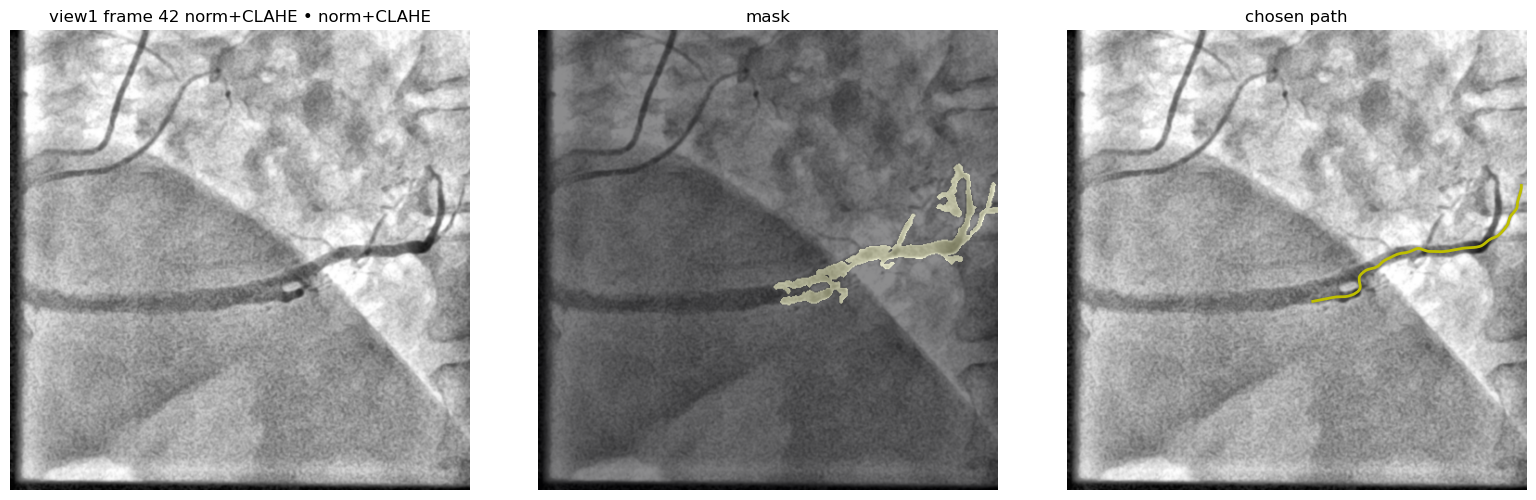

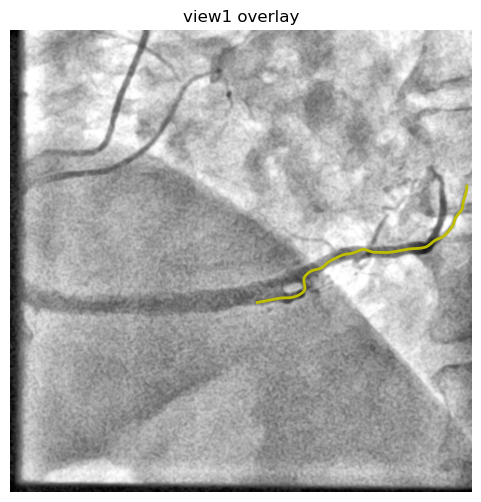

DeepSA returned a mask with 10928 pixels; using it.


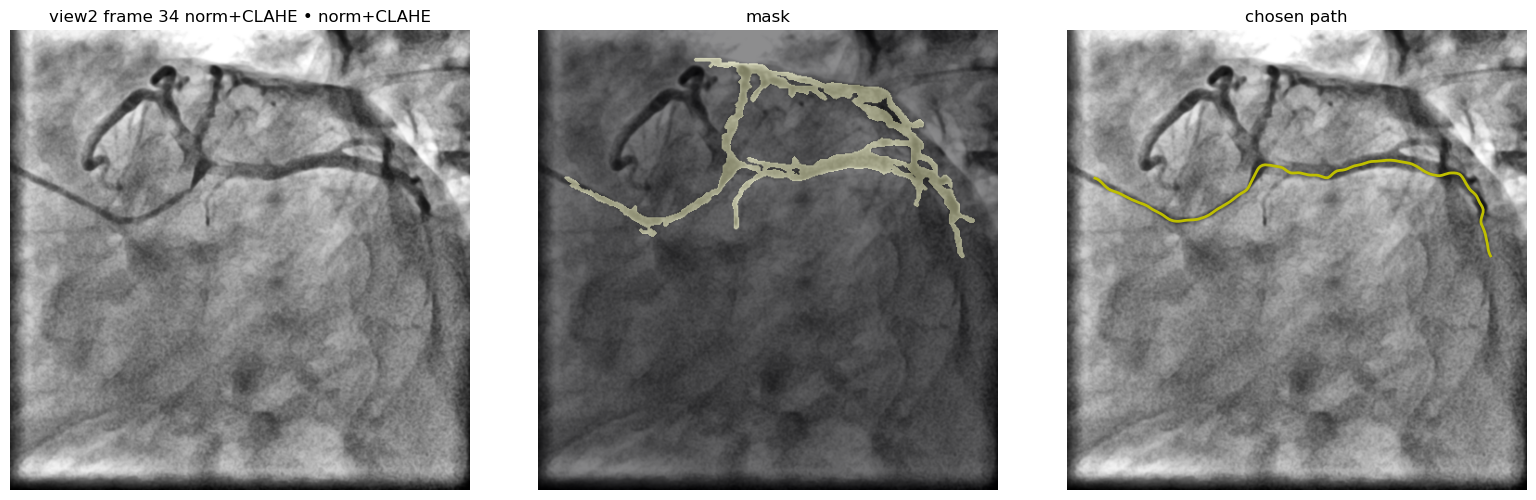

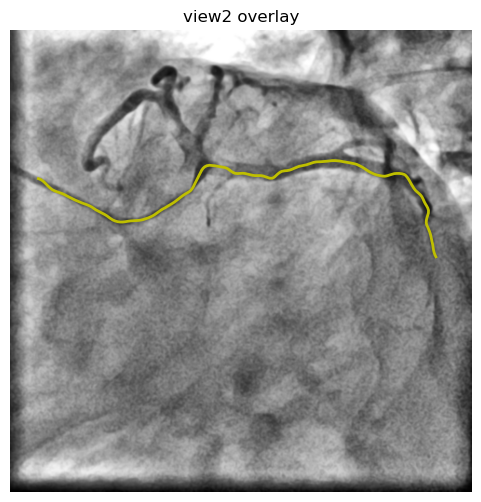

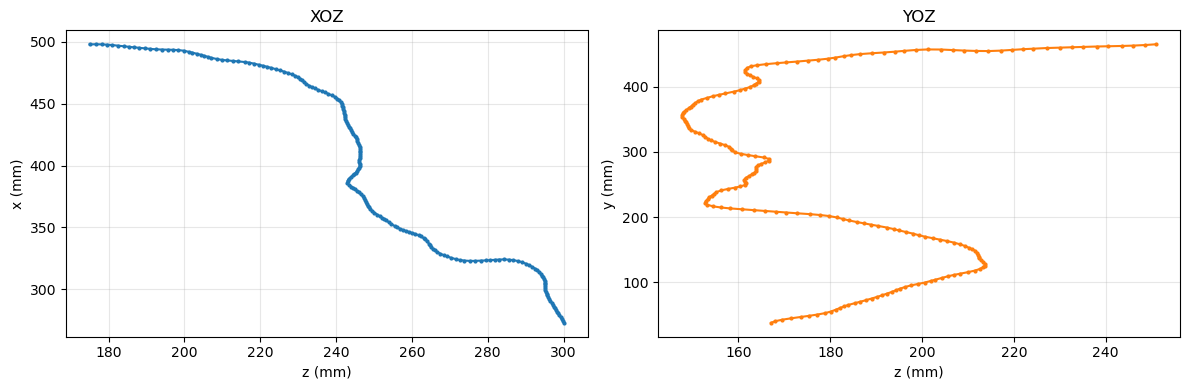

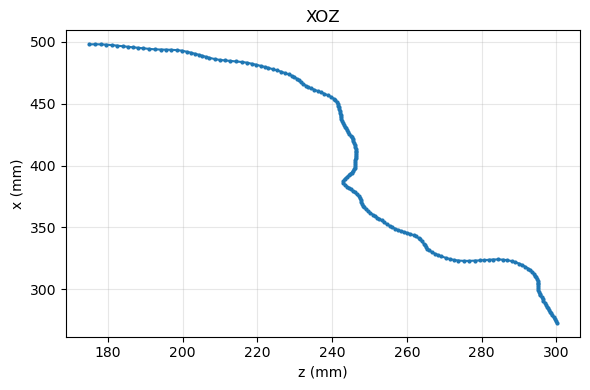

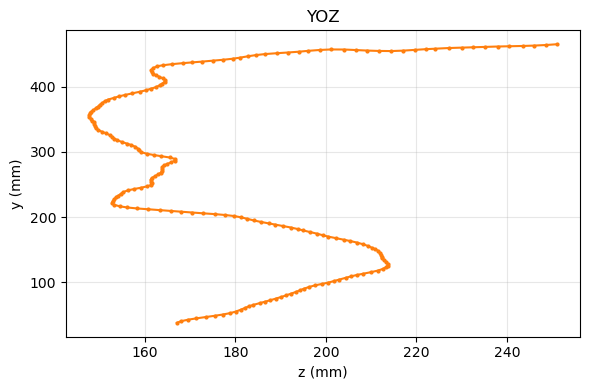

In [17]:
deepsa = DeepSAWrapper("DeepSA")

# View #5 is XOZ, #4 is YOZ in your case
xoz_pts, yoz_pts = visualize_full_results(
    patient_folder="Data/初赛数据-血管造影图像/患者3-血管造影图像",
    pair=(5,4),
    planes=("XOZ","YOZ"),
    deepsa=deepsa,
    #fixed_frames=(41, 44), 
    save_dir="patient_3_results"
)

In [34]:
theta_best, rms_best, ise_best, t, Xg, Yg, Zg = fit_parametric_3d_multistart(
    "patient_1_results/xoz.csv",
    "patient_1_results/yoz.csv",
    "./patient_1_results",
    base_cfg=FitConfig(n_grid=2000, eps_monotone=1e-4, max_nfev=25000),
    n_starts=60,                                # bump up if you want
    try_freq_hi=(6*np.pi, 10*np.pi, 20*np.pi),  # slow → moderate oscillations
    try_monopen=(5.0, 20.0),                    # weak vs. strong monotonicity
    verbose=True
)
print("Best params (a..i):", [f"{v:.8f}" for v in theta_best])
print("RMS:", f"{rms_best:.8f}", "ISE:", f"{ise_best:.8f}")

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_34064\4092450688.py:228: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ise = np.trapz(err2, t)


[001] freq_hi=6.0π  mono_pen=5.0    RMS=393.4784  ISE=154809.0545  nfev=2312
[002] freq_hi=6.0π  mono_pen=5.0    RMS=399.6855  ISE=159734.1264  nfev=329
[003] freq_hi=6.0π  mono_pen=5.0    RMS=400.8674  ISE=160685.4838  nfev=83
[004] freq_hi=6.0π  mono_pen=5.0    RMS=393.1495  ISE=154572.6634  nfev=179
[005] freq_hi=6.0π  mono_pen=5.0    RMS=401.7783  ISE=161416.7387  nfev=62
[006] freq_hi=6.0π  mono_pen=5.0    RMS=401.2144  ISE=160980.5610  nfev=225
[007] freq_hi=6.0π  mono_pen=5.0    RMS=389.6249  ISE=151774.0765  nfev=1183
[008] freq_hi=6.0π  mono_pen=5.0    RMS=282.6100  ISE=79862.7164  nfev=24
[009] freq_hi=6.0π  mono_pen=5.0    RMS=381.6667  ISE=145634.7325  nfev=1808
[010] freq_hi=6.0π  mono_pen=5.0    RMS=394.6914  ISE=155786.9515  nfev=254
[011] freq_hi=6.0π  mono_pen=5.0    RMS=380.6803  ISE=144883.1481  nfev=5720
[012] freq_hi=6.0π  mono_pen=5.0    RMS=400.6252  ISE=160485.6916  nfev=1305
[013] freq_hi=6.0π  mono_pen=5.0    RMS=399.0863  ISE=159281.7021  nfev=1843
[014] freq